In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial import Voronoi

import py4DSTEM
from py4DSTEM.process.utils import get_maxima_2D, get_voronoi_vertices
from py4DSTEM.process.classification import BraggVectorClassification

In [2]:
fp = "/home/ben/Data/20190128_ClassificationData/EASY_binDiffraction4.h5"
#fp = "/Users/Ben/Desktop/EASY_binDiffraction4_no_datacube.h5"
browser = py4DSTEM.file.io.FileBrowser(fp)
ave_im = browser.get_dataobject('average_image').data2D
braggvectormap = browser.get_dataobject('deconvolution').data2D
braggpeaks = browser.get_dataobject('Bragg_peaks')
browser.close()

Q_Nx, Q_Ny = braggvectormap.shape
R_Nx,R_Ny = ave_im.shape

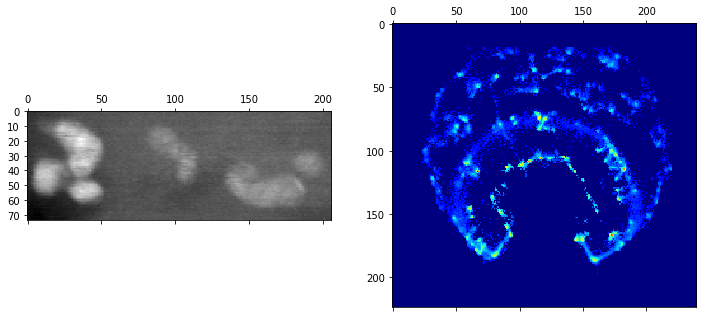

In [4]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ax1.matshow(ave_im)
ax2.matshow(braggvectormap**0.2,cmap='jet')
plt.show()

In [5]:
# # Uncomment this cell to use the Bragg vector *maxima* map, rather than the Bragg vector map

# braggvectormap = py4DSTEM.process.braggdiskdetection.get_bragg_vector_maxima_map(braggpeaks,Q_Nx,Q_Ny)

# fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
# ax1.matshow(ave_im)
# ax2.matshow(braggvectormap**0.5,cmap='jet')
# plt.show()

### Get Bragg vector map maxima

for labelling the Bragg peaks

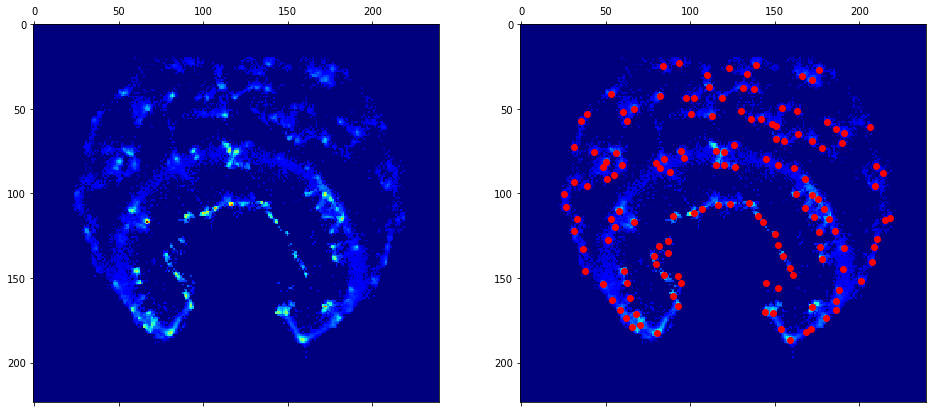

In [19]:
# Get Bragg vector map maxima

sigma = 1
edgeBoundary = 0
minSpacing = 0
minRelativeIntensity = 0.0005
relativeToPeak = 0
maxNumPeaks = 1000
subpixel = True

power = 0.25
scale = 0     # Set scale to 0 to plot all BPs as the same size

maxima_x, maxima_y, maxima_int = get_maxima_2D(braggvectormap, sigma=sigma, edgeBoundary=edgeBoundary,
                                               minSpacing=minSpacing, minRelativeIntensity=minRelativeIntensity,
                                               relativeToPeak=relativeToPeak, maxNumPeaks=maxNumPeaks,
                                               subpixel=subpixel)
N = len(maxima_x)

# Show
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(braggvectormap**power,cmap='jet')
ax2.matshow(braggvectormap**power,cmap='jet')
if scale==0:
    ax2.scatter(maxima_y,maxima_x,color='r')
else:
    ax2.scatter(maxima_y,maxima_x,color='r',
                s=scale*maxima_int/np.max(maxima_int))
plt.show()

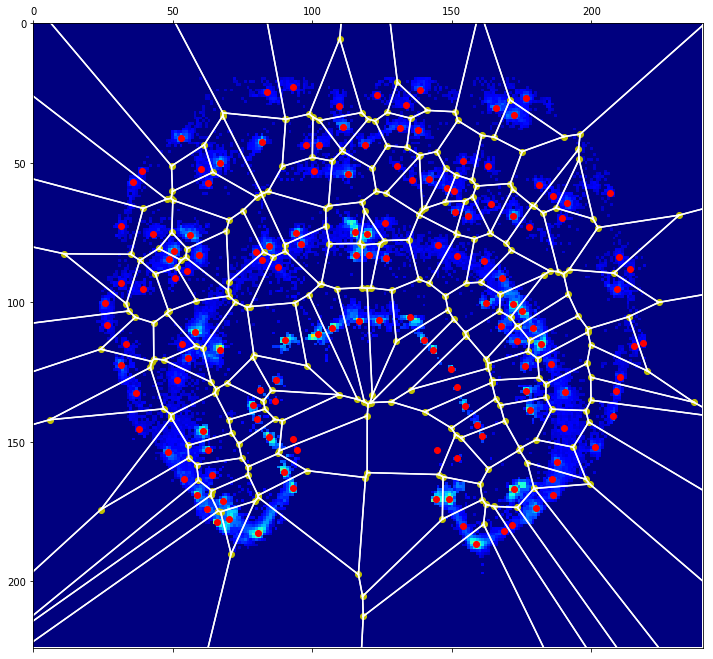

In [17]:
# For display - make Voronoi diagram
points = np.vstack((maxima_x,maxima_y)).T
voronoi = Voronoi(points)

# Get vertices
vertices = get_voronoi_vertices(voronoi, Q_Nx, Q_Ny)

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap**0.25,cmap='jet')
ax.scatter(voronoi.points[:,1],voronoi.points[:,0],color='r')
ax.scatter(voronoi.vertices[:,1],voronoi.vertices[:,0],color='y')
for region in range(len(vertices)):
    vertices_curr = vertices[region]
    for i in range(len(vertices_curr)):
        x0,y0 = vertices_curr[i,:]
        x1,y1 = vertices_curr[(i+1)%len(vertices_curr),:]
        ax.plot((y0,y1),(x0,x1),'w')        
ax.set_xlim([0,braggvectormap.shape[1]])
ax.set_ylim([0,braggvectormap.shape[0]])
plt.gca().invert_yaxis()
plt.show()

### Visualization helper functions

In [20]:
def show_class(classification, class_index, sizescale=100, show_current=True):
    """
    Display a single class from a classification, plotting both the BPs and the class image.
    
    Accepts:
        classification        (BraggVectorClassification) the classification
        class_index           (int) the class to show
        sizescale             (float) the size of the BP markers
        show_current          (bool) if True, show current class states. If False, show candidate states.
    """
    if show_current:
        class_BPs, class_image = classification.get_class(class_index)
    else:
        class_BPs, class_image = classification.get_candidate_class(class_index)

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
    ax1.matshow(braggvectormap**power,cmap='jet')
    ax1.scatter(classification.Qy,classification.Qx,color='y')
    for i in range(N):
        ax1.scatter(classification.Qy[i],classification.Qx[i],color='r',s=sizescale*class_BPs[i])
    ax1.grid(False)
    ax2.matshow(class_image)
    ax2.grid(False)
    plt.show()
    
def show_classes(classification, sizescale=100, show_current=True, ncols=4,
                 label=True, labeloffset=5, labelsize=24, labelcolor='w', prunefactor=1):
    """
    Display all classes in a classification, plotting both the BPs and the class image for each class, in a grid.
    
     Accepts:
        classification        (BraggVectorClassification) the classification
        class_index           (int) the class to show
        sizescale             (float) the size of the BP markers
        show_current          (bool) if True, show current class states. If False, show candidate states.
        ncols                 (int) the number of columns in the display grid
        label                 (bool) if True, print the class index in the corner of each class
        labeloffset           (float) controls how far from the plot corner the class index labels are printed
        labelsize             (float) class index label print size
        labelcolor            (a matplotlib color)
        prunefactor           (int) show only the prunefactor'th class
    """
    if show_current:
        N_c = classification.N_c
    else:
        N_c = classification.N_c_next
    N_classes = N_c//prunefactor
    nrows = int(np.ceil((N_classes)/ncols))

    fig,axs = plt.subplots(nrows,2*ncols,figsize=(16*ncols,8*nrows))

    for index in range(N_classes):
        ax1 = axs[int(index%nrows),int(2*(index//nrows))]
        ax2 = axs[int(index%nrows),int(2*(index//nrows)+1)]

        if show_current:
            class_BPs, class_image = classification.get_class(index*prunefactor)
        else:
            class_BPs, class_image = classification.get_candidate_class(index*prunefactor)

        ax1.matshow(braggvectormap**power,cmap='jet')
        ax1.scatter(maxima_y,maxima_x,color='y')
        for i in range(N):
            ax1.scatter(maxima_y[i],maxima_x[i],color='r',s=sizescale*class_BPs[i])
        ax2.matshow(class_image)
        
        if label:
            ax1.text(labeloffset,labeloffset+labelsize/2,"{}".format(index*prunefactor),size=labelsize,color=labelcolor)
        
        ax1.grid(False)
        ax2.grid(False)

    plt.show()

def show_class_image(classification, class_index, thresh=0.3, cmap='hsv', show_current=True):
    """
    Display a single class image.
    
     Accepts:
        classification        (BraggVectorClassification) the classification
        class_index           (int) the class to show
        cmap                  (a matplotlib colormap)
        show_current          (bool) if True, show current class states. If False, show candidate states.
    """
    if show_current:
        N_c = classification.N_c
    else:
        N_c = classification.N_c_next
    nrows = int(np.ceil(N_c/ncols))
    
    cmap_base = get_cmap(cmap)
    fig,ax = plt.subplots(figsize=(12,12))
    ax.matshow(np.zeros((R_Nx,R_Ny)))
    for index in range(N_c):
        if show_current:
            class_image = classification.get_class_image(index)
        else:
            class_image = classification.get_candidate_class_image(index)

        ma = np.ma.array(class_image, mask = class_image<thresh)
        if not np.all(ma.mask):
            colors = [(0,0,0,1),cmap_base(index/N_c)]
            cm = LinearSegmentedColormap.from_list('cmap', colors, N=100)
            ax.matshow(ma,cmap=cm)
    plt.show()

def show_class_images(classification, class_indices, thresh=0.3, cmap='hsv', show_current=True):
    """
    Display a subset of the class images, overlaid in a single plot.
    
     Accepts:
        classification        (BraggVectorClassification) the classification
        class_indices         (list or tuple of ints) the classes to overlay
        cmap                  (a matplotlib colormap)
        show_current          (bool) if True, show current class states. If False, show candidate states.
    """
    if show_current:
        N_c = classification.N_c
    else:
        N_c = classification.N_c_next
    cmap_base = get_cmap(cmap)
    fig,ax = plt.subplots(figsize=(12,12))
    ax.matshow(np.zeros((R_Nx,R_Ny)))
    for index in class_indices:
        if show_current:
            class_image = classification.get_class_image(index)
        else:
            class_image = classification.get_candidate_class_image(index)

        ma = np.ma.array(class_image, mask = class_image<thresh)
        if not np.all(ma.mask):
            colors = [(0,0,0,1),cmap_base(index/N_c)]
            cm = LinearSegmentedColormap.from_list('cmap', colors, N=100)
            ax.matshow(ma,cmap=cm)
    plt.show()
    
def show_classification(classification, thresh=0.3, cmap='hsv', show_current=True):
    """
    Display all class images, overlaid in a single plot.
    
     Accepts:
        classification        (BraggVectorClassification) the classification
        cmap                  (a matplotlib colormap)
        show_current          (bool) if True, show current class states. If False, show candidate states.
    """
    if show_current:
        N_c = classification.N_c
    else:
        N_c = classification.N_c_next
    cmap_base = get_cmap(cmap)
    fig,ax = plt.subplots(figsize=(12,12))
    ax.matshow(np.zeros((R_Nx,R_Ny)))
    for index in range(N_c):
        if show_current:
            class_image = classification.get_class_image(index)
        else:
            class_image = classification.get_candidate_class_image(index)

        ma = np.ma.array(class_image, mask = class_image<thresh)
        if not np.all(ma.mask):
            colors = [(0,0,0,1),cmap_base(index/N_c)]
            cm = LinearSegmentedColormap.from_list('cmap', colors, N=100)
            ax.matshow(ma,cmap=cm)
    plt.show()

def show_stepwise_classification(classification, thresh=0.3, cmap='hsv', show_current=True, aspect_ratio=1, ncols=1,
                                 label=True, labeloffset=5, labelsize=24, labelcolor='w', prunefactor=1):
    """
    Display class image overlays in N_c plots, adding classes one by one in each successive plot.
    
     Accepts:
        classification        (BraggVectorClassification) the classification
        cmap                  (a matplotlib colormap)
        show_current          (bool) if True, show current class states. If False, show candidate states.
        aspect_ratio          (float) the width:height aspect ratio of the image. For scaling the figsize.
        ncols                 (int) the number of columns in the display grid
        label                 (bool) if True, print the class index in the corner of each class
        labeloffset           (float) controls how far from the plot corner the class index labels are printed
        labelsize             (float) class index label print size
        labelcolor            (a matplotlib color)
        prunefactor           (int) show only the prunefactor'th class
    """
    if show_current:
        N_c = classification.N_c
    else:
        N_c = classification.N_c_next
    N_classes = N_c//prunefactor
    ncols = int(ncols)
    nrows = int(np.ceil(N_classes/ncols))
    cmap_base = get_cmap(cmap)
    fig,axs = plt.subplots(nrows,ncols,figsize=(12*ncols,12*nrows/aspect_ratio))
    for i in range(N_classes):
        if ncols==1:
            ax = axs[i]
        else:
            ax = axs[i%nrows,i//nrows]
        ax.matshow(np.zeros((R_Nx,R_Ny)))
        for index in np.arange(i*prunefactor+1):
            if show_current:
                class_image = classification.get_class_image(index)
            else:
                class_image = classification.get_candidate_class_image(index)

            ma = np.ma.array(class_image, mask = class_image<thresh)
            if not np.all(ma.mask):
                colors = [(0,0,0,1),cmap_base(index/N_c)]
                cm = LinearSegmentedColormap.from_list('cmap', colors, N=100)
                ax.matshow(ma,cmap=cm)
                    
        if label:
            ax.text(labeloffset,labeloffset+labelsize/2,"{}".format(index),size=labelsize,color=labelcolor)
    
    plt.show()
    
def show_merge_candidates(classification, merge_candidates, n_merge_candidate, thresh=0.1, sizescale=100,
                          label=True, labeloffset=5, labelsize=18, labelcolor='w'):
    """
    Display class image overlays in N_c plots, adding classes one by one in each successive plot.
    
     Accepts:
        classification        (BraggVectorClassification) the classification
        merge_candidates      (structured array) specifies the merge candidates; see BraggVectorClassification.merge docstring.
        n_merge_candidate     (int) which merge candidate pair to show
        thresh                (float) the scan position threshold, below which the class image is not populated
        sizescale             (float) the size of the BP markers
        label                 (bool) if True, print the class index in the corner of each class
        labeloffset           (float) controls how far from the plot corner the class index labels are printed
        labelsize             (float) class index label print size
        labelcolor            (a matplotlib color)
    """
    class_i = merge_candidates['i'][n_merge_candidate]
    class_j = merge_candidates['j'][n_merge_candidate]

    class_BPs_i,class_map_i = classification.get_class(class_i)
    class_BPs_j,class_map_j = classification.get_class(class_j)
    ma_i = np.ma.array(class_map_i, mask = class_map_i<thresh)
    ma_j = np.ma.array(class_map_j, mask = class_map_j<thresh)

    fig = plt.figure(figsize=(18,15))
    gs = gridspec.GridSpec(ncols=6,nrows=5,figure=fig)
    ax11 = fig.add_subplot(gs[:3,:3])
    ax12 = fig.add_subplot(gs[:3,3:])
    ax3 = fig.add_subplot(gs[3:,:])

    ax11.matshow(braggvectormap**power,cmap='jet')
    ax11.scatter(maxima_y,maxima_x,color='y')
    for i in range(N):
        ax11.scatter(maxima_y[i],maxima_x[i],color='r',s=sizescale*class_BPs_i[i])

    ax12.matshow(braggvectormap**power,cmap='jet')
    ax12.scatter(maxima_y,maxima_x,color='y')
    for i in range(N):
        ax12.scatter(maxima_y[i],maxima_x[i],color='r',s=sizescale*class_BPs_j[i])

    ax3.matshow(np.zeros((R_Nx,R_Ny)))
    ax3.matshow(ma_i,cmap='Reds')
    ax3.matshow(ma_j,cmap='Blues')

    ax11.grid(False)
    ax12.grid(False)
    ax3.grid(False)

    if label:
        ax11.text(labeloffset,Q_Nx-labeloffset-2*labelsize,s=r'cc$_W$ = {:.2}'.format(merge_candidates['cc_w'][n_merge_candidate]),color=labelcolor,size=labelsize)
        ax11.text(labeloffset,Q_Nx-labeloffset-labelsize,s=r'cc$_H$ = {:.2}'.format(merge_candidates['cc_h'][n_merge_candidate]),color=labelcolor,size=labelsize)
        ax11.text(labeloffset,Q_Nx-labeloffset,s=r'cc$_H$*cc$_H$ = {:.2}'.format(merge_candidates['score'][n_merge_candidate]),color=labelcolor,size=labelsize)

    plt.show()    

### Classification

In [27]:
thresh = 0.3                # Determines when to stop adding new BPs to the initial classes
BP_fraction_thresh = 0.1
max_iterations = 200        # Maximum number of initial classes
X_is_boolean = True
n_corr_init = 3

classification = BraggVectorClassification(braggpeaks, maxima_x, maxima_y,
                                           thresh = thresh,
                                           BP_fraction_thresh = BP_fraction_thresh,
                                           max_iterations = max_iterations,
                                           X_is_boolean = X_is_boolean,
                                           n_corr_init=n_corr_init)

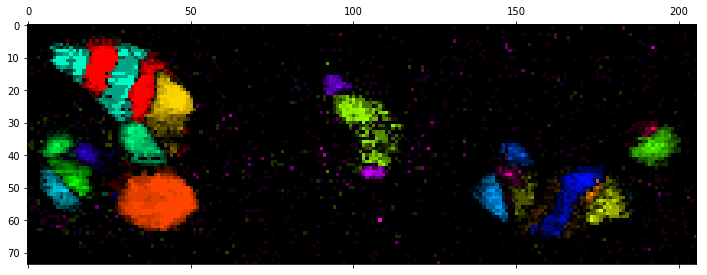

In [33]:
# Show class image overlay

thresh = 0.3
cmap = 'hsv'
show_current = True

show_classification(classification, thresh=thresh, cmap=cmap, show_current=show_current)

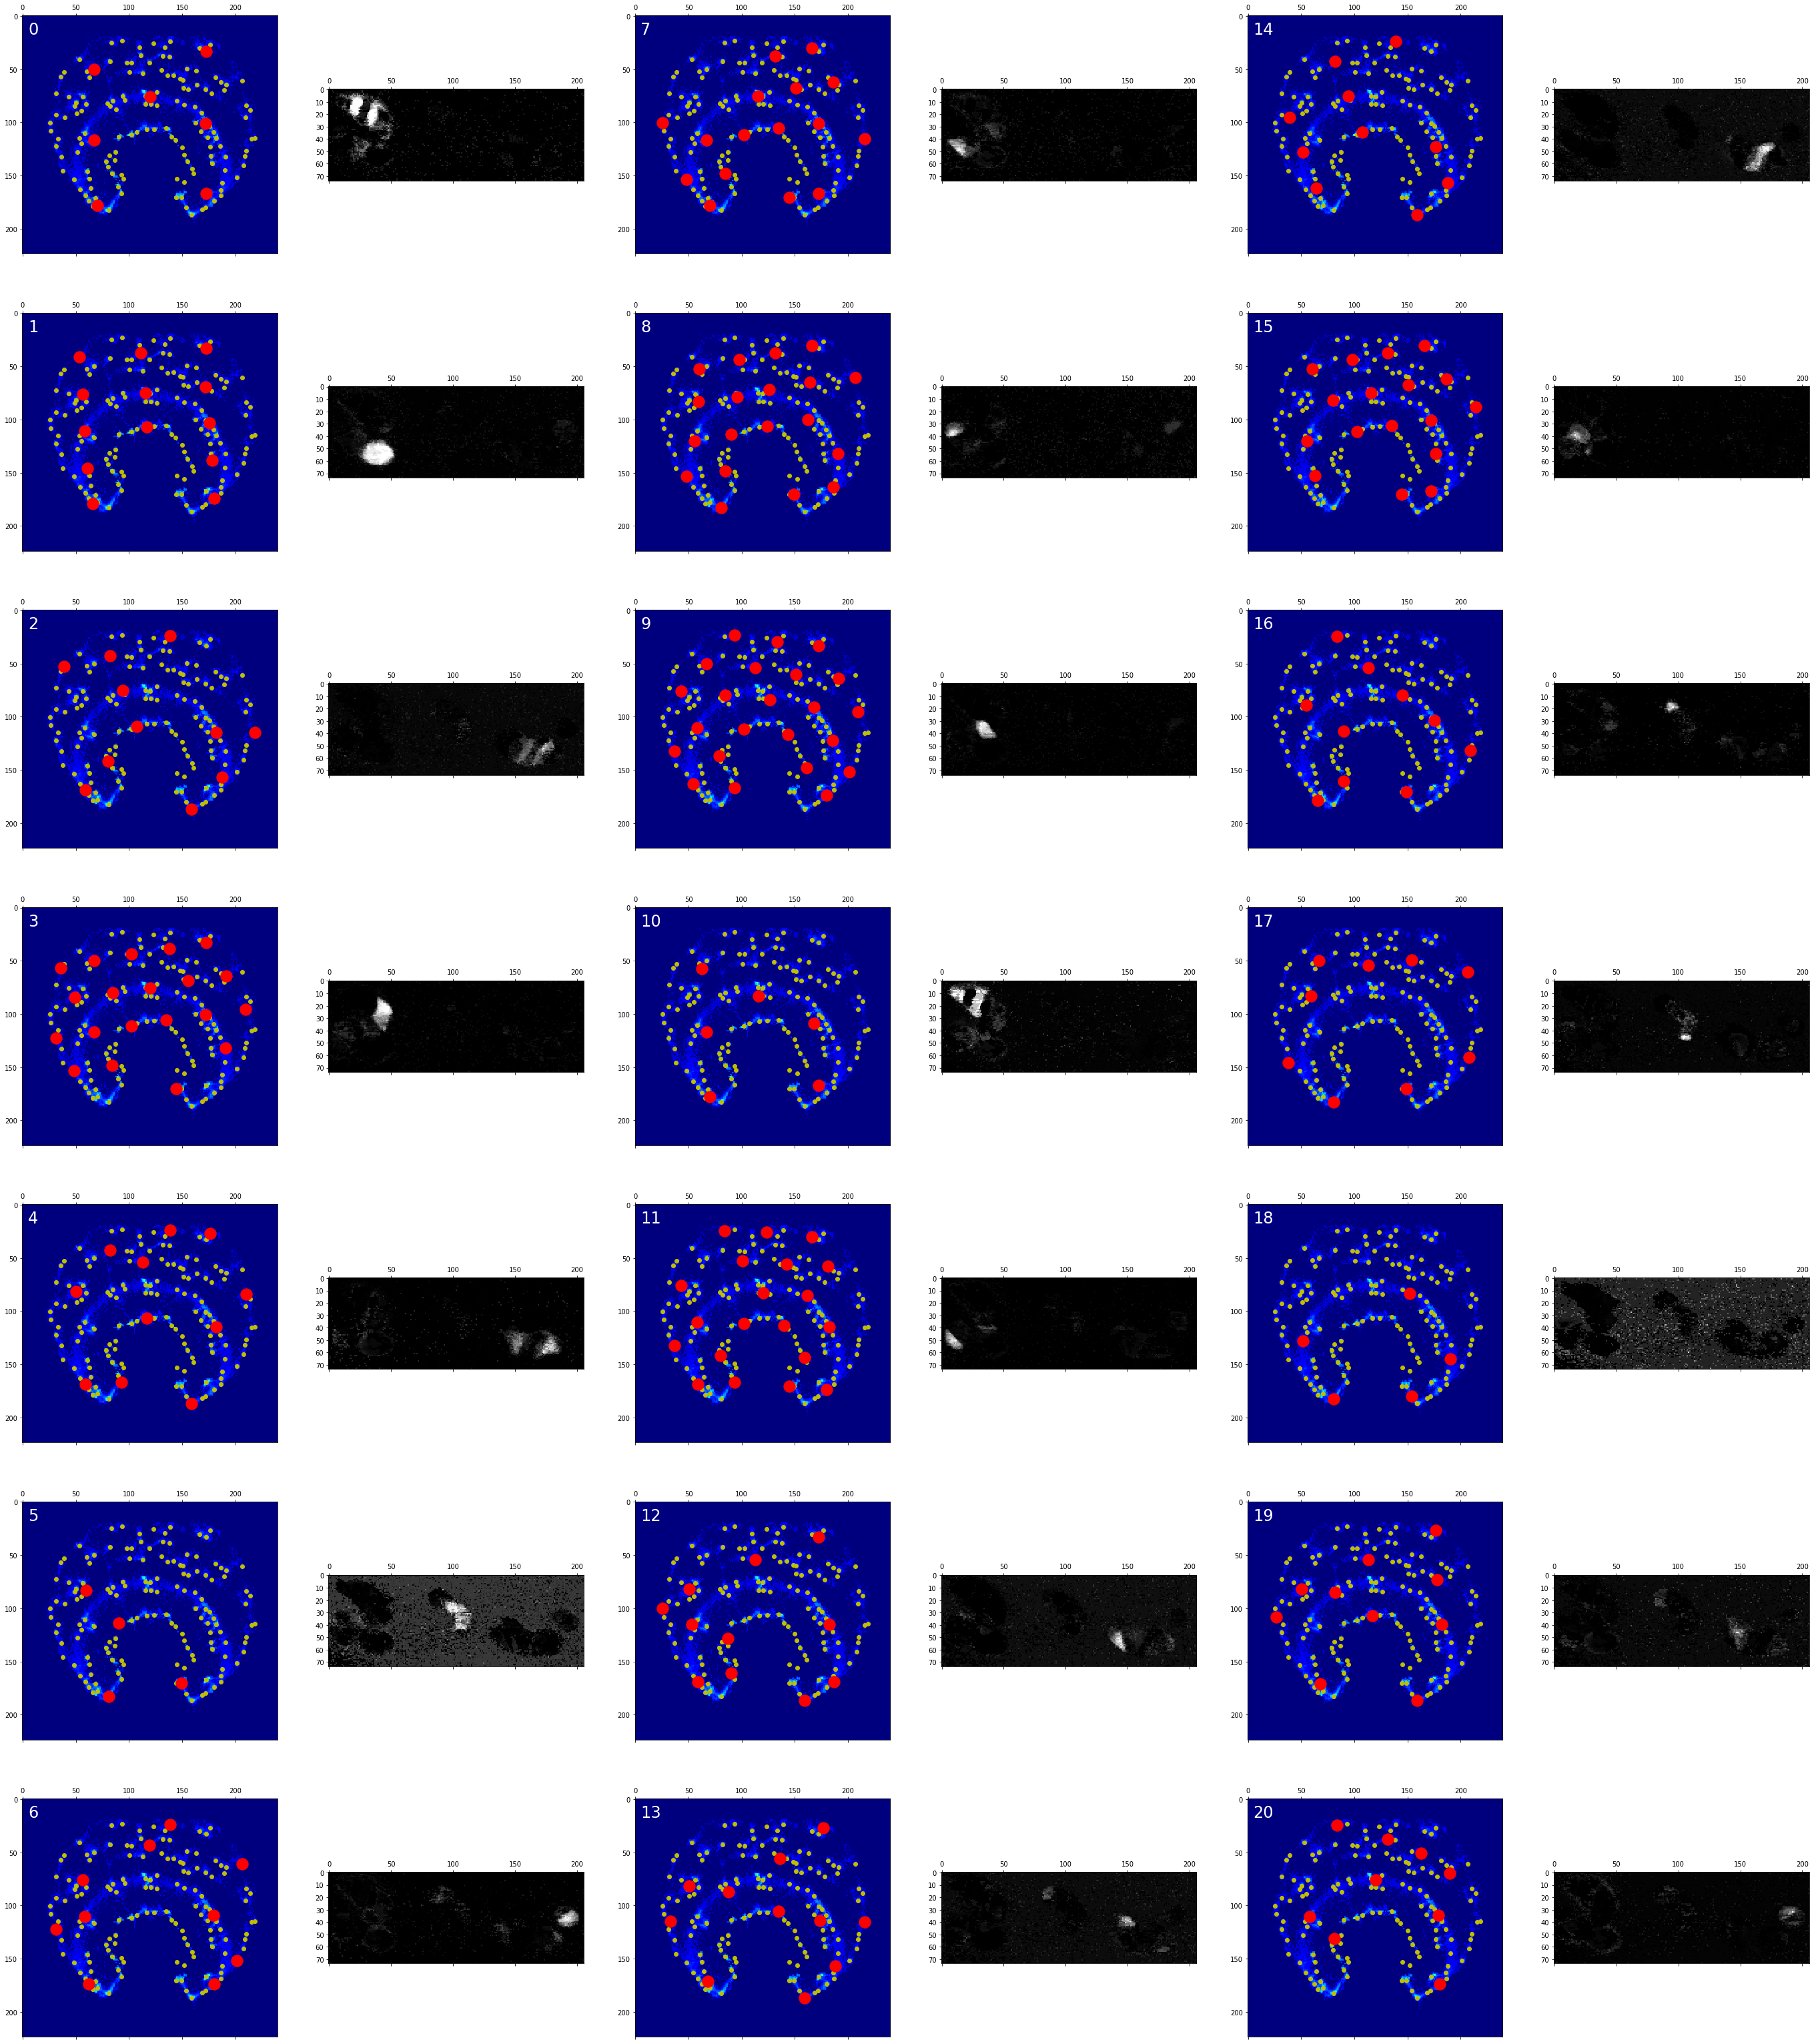

In [29]:
# Show all classes

sizescale = 300
show_current = True
ncols = 3
label = True
labeloffset = 5
labelsize = 24
labelcolor = 'w'
prunefactor = 1

show_classes(classification, sizescale=sizescale, show_current=show_current, ncols=ncols,
             label=label, labeloffset=labeloffset, labelsize=labelsize, labelcolor=labelcolor,
             prunefactor=prunefactor)

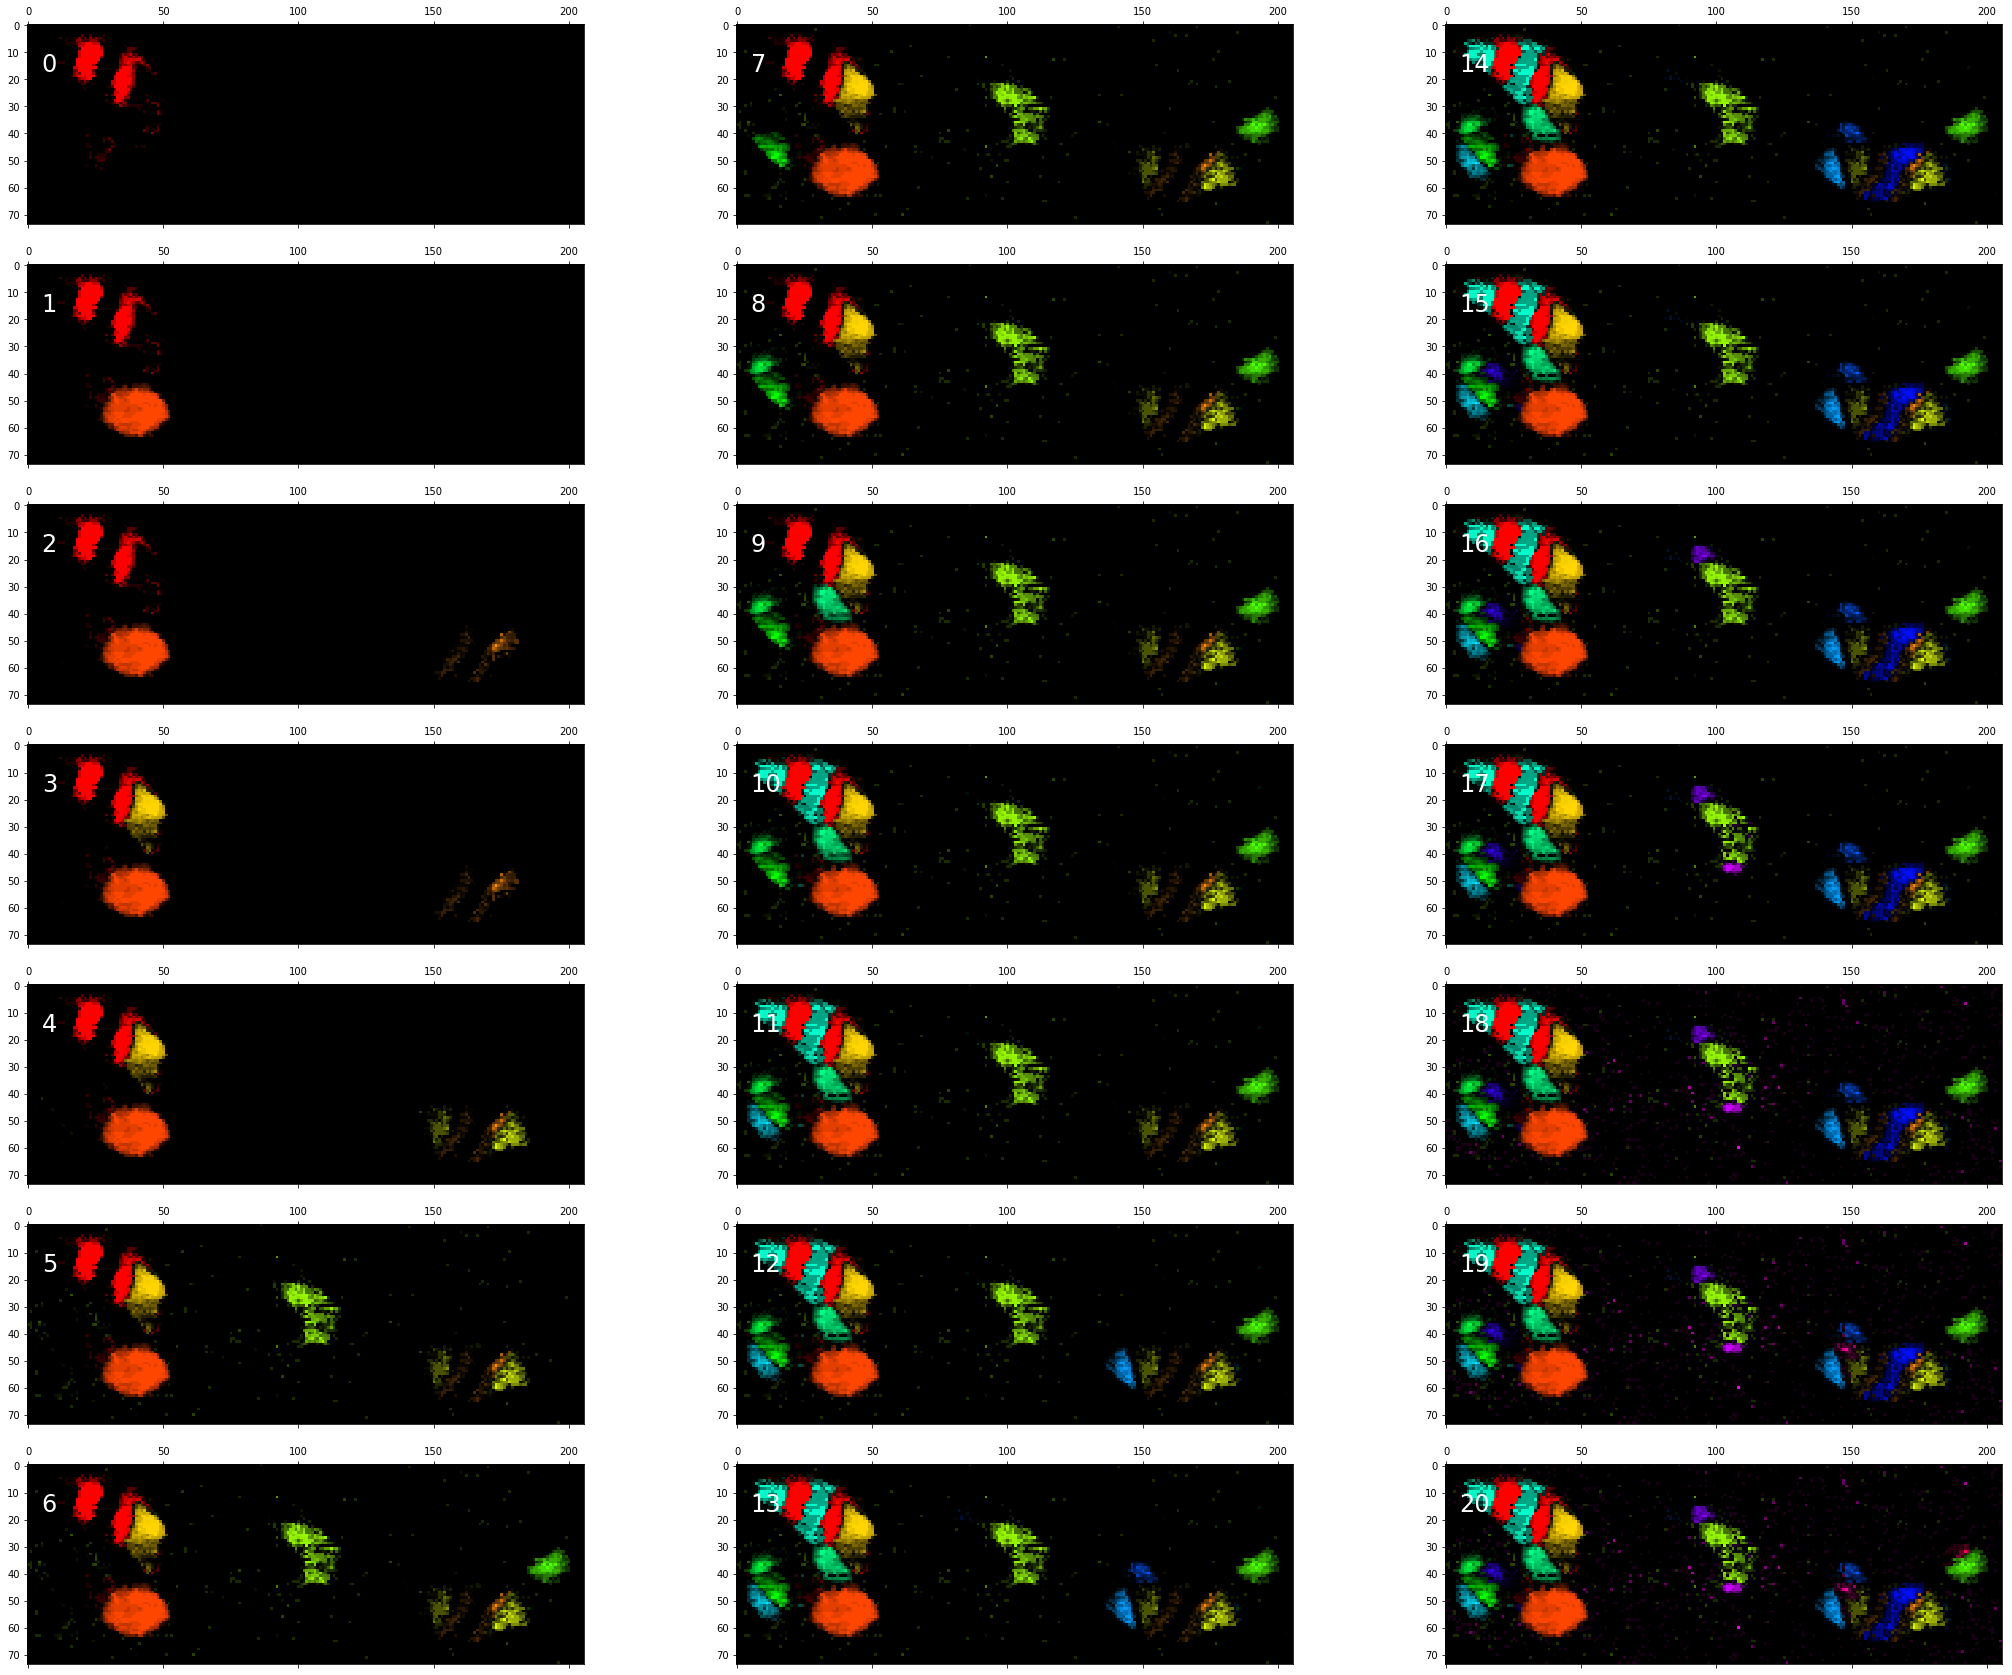

In [30]:
# Show successive class image overlay

thresh = 0.3
cmap = 'hsv'
show_current = True
ncols=3
label = True
labeloffset = 5
labelsize = 24
labelcolor = 'w'
prunefactor = 1

aspect_ratio = classification.get_class_image(0).shape[1]/classification.get_class_image(0).shape[0]
show_stepwise_classification(classification, thresh=thresh, cmap=cmap, show_current=show_current,
                             aspect_ratio=aspect_ratio, ncols=ncols,
                             label=label, labeloffset=labeloffset, labelsize=labelsize, labelcolor=labelcolor,
                             prunefactor=prunefactor)

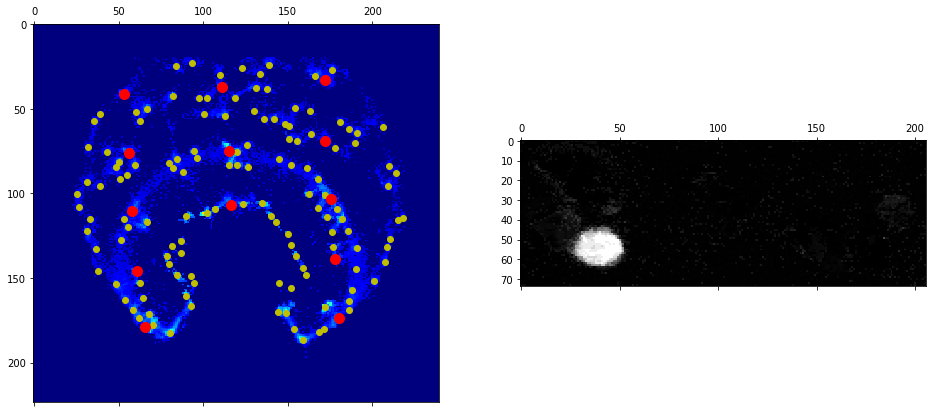

In [35]:
# Show one class

class_index = 1
sizescale = 100
show_current = True

show_class(classification=classification, class_index=class_index, sizescale=sizescale, show_current=show_current)

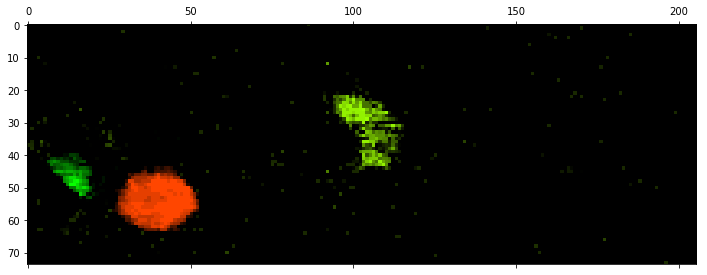

In [56]:
# Show class image overlay

thresh = 0.3
class_indices = [1,5,7]
cmap = 'hsv'
show_current = True

show_class_images(classification, class_indices, thresh=thresh, cmap=cmap, show_current=show_current)

### Split

In [116]:
sigma = 2
threshold_split = 0.25
expand_mask = 1

classification.split(sigma=sigma, threshold_split=threshold_split, expand_mask=expand_mask)

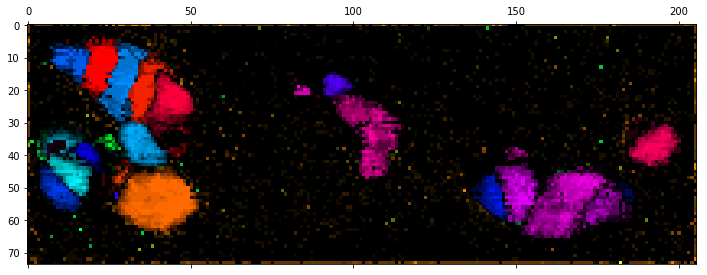

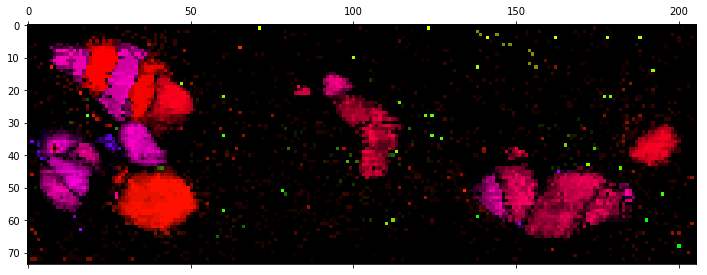

In [117]:
# Show class image overlay

thresh = 0.3
cmap = 'hsv'

show_classification(classification, thresh=thresh, cmap=cmap, show_current=True)
show_classification(classification, thresh=thresh, cmap=cmap, show_current=False)

In [118]:
# Show all classes

sizescale = 300
show_current = False
ncols = 3
label = True
labeloffset = 5
labelsize = 24
labelcolor = 'w'
prunefactor = 1

show_classes(classification, sizescale=sizescale, show_current=show_current, ncols=ncols,
             label=label, labeloffset=labeloffset, labelsize=labelsize, labelcolor=labelcolor,
             prunefactor=prunefactor)

KeyboardInterrupt: 

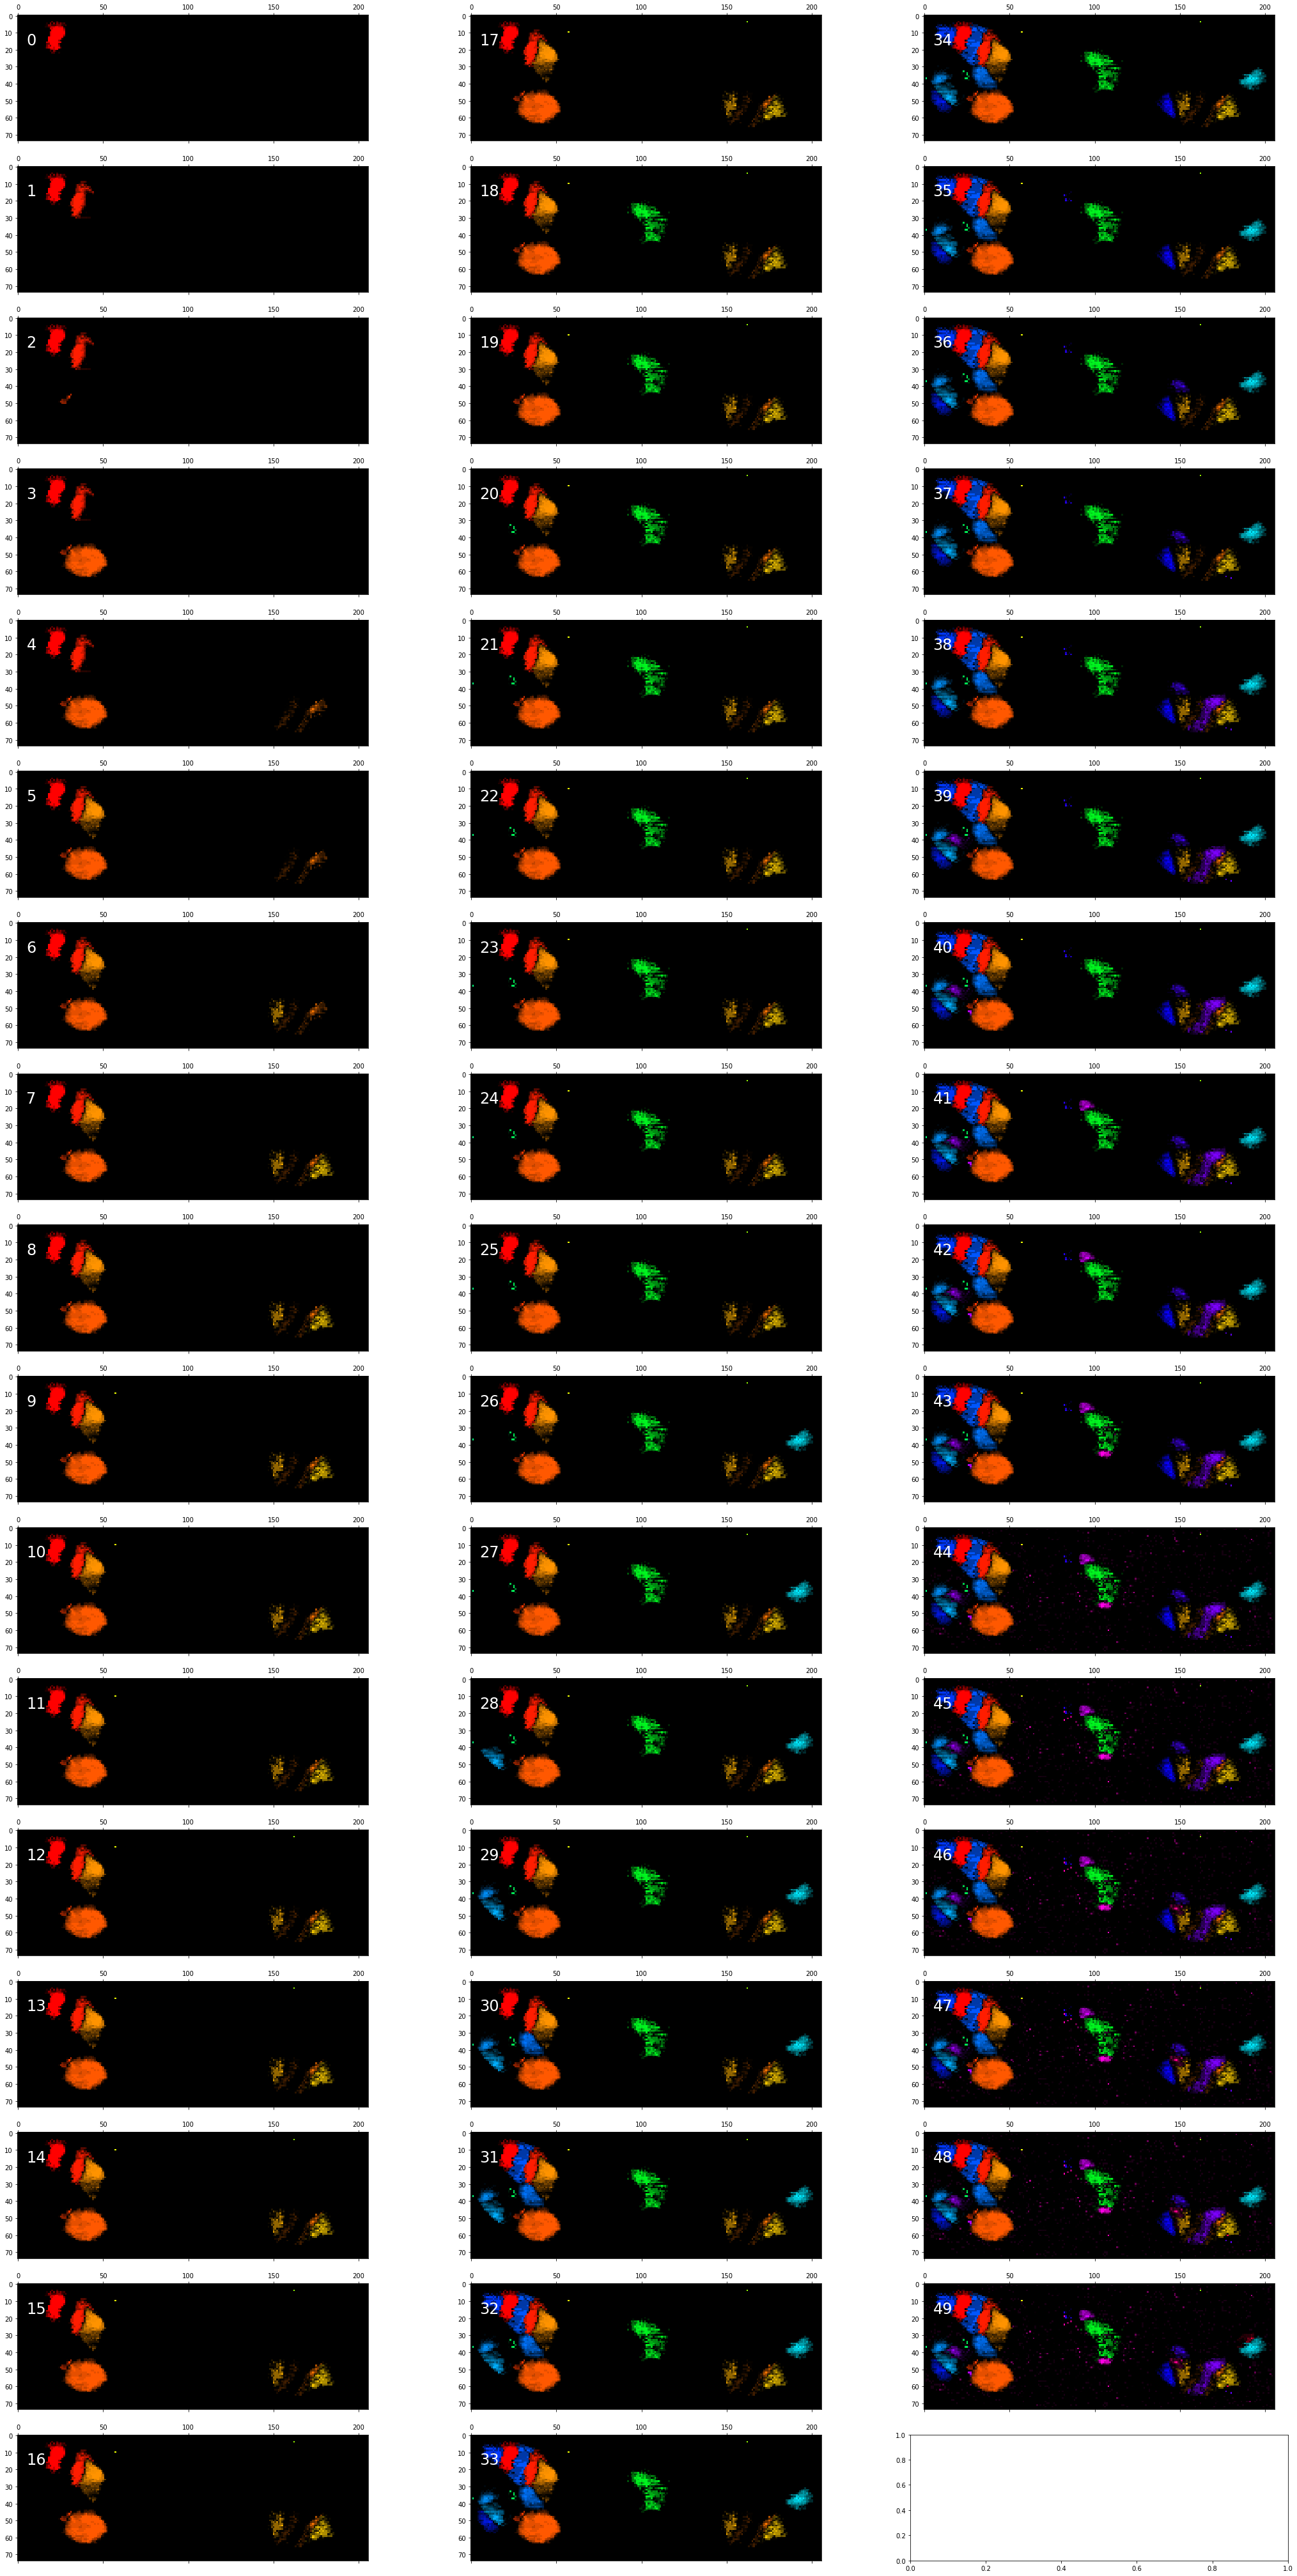

In [72]:
# Show successive class image overlay

thresh = 0.3
cmap = 'hsv'
show_current = False
ncols=3
label = True
labeloffset = 5
labelsize = 24
labelcolor = 'w'
prunefactor = 1

aspect_ratio = classification.get_class_image(0).shape[1]/classification.get_class_image(0).shape[0]
show_stepwise_classification(classification, thresh=thresh, cmap=cmap, show_current=show_current,
                             aspect_ratio=aspect_ratio, ncols=ncols,
                             label=label, labeloffset=labeloffset, labelsize=labelsize, labelcolor=labelcolor,
                             prunefactor=prunefactor)

In [70]:
classification.accept()

In [ ]:
classification.reject()

### Merge

In [48]:
threshBPs = 0.25
threshScanPosition = 0.05
return_params = True

W_corr, H_corr, merge_candidates = classification.merge(threshBPs=threshBPs, threshScanPosition=threshScanPosition,
                                                        return_params=return_params)

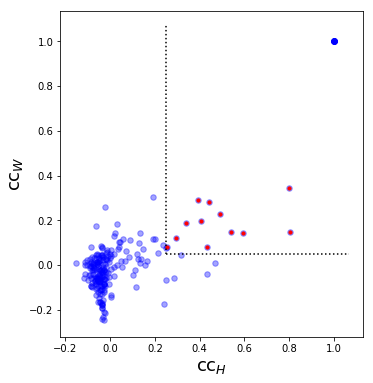

In [49]:
# Show correlations and merge thresholds

fig,ax = plt.subplots(figsize=(6,6))
ax.scatter(W_corr.ravel(),H_corr.ravel(),alpha=0.2,color='b',s=30)
ax.scatter(merge_candidates['cc_w'],merge_candidates['cc_h'],color='r',s=10)
ax.hlines(threshScanPosition,threshBPs,ax.get_xlim()[1],linestyle=":")
ax.vlines(threshBPs,threshScanPosition,ax.get_ylim()[1],linestyle=":")
ax.set_aspect('equal')
ax.set_xlabel(r"cc$_H$",size=18)
ax.set_ylabel(r"cc$_W$",size=18)
plt.show()

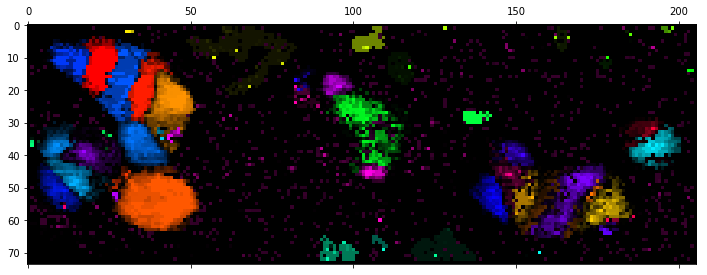

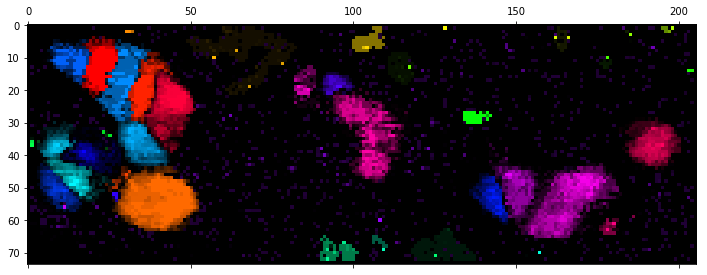

In [91]:
# Show class image overlay

thresh = 0.2
cmap = 'hsv'

show_classification(classification, thresh=thresh, cmap=cmap, show_current=True)
show_classification(classification, thresh=thresh, cmap=cmap, show_current=False)

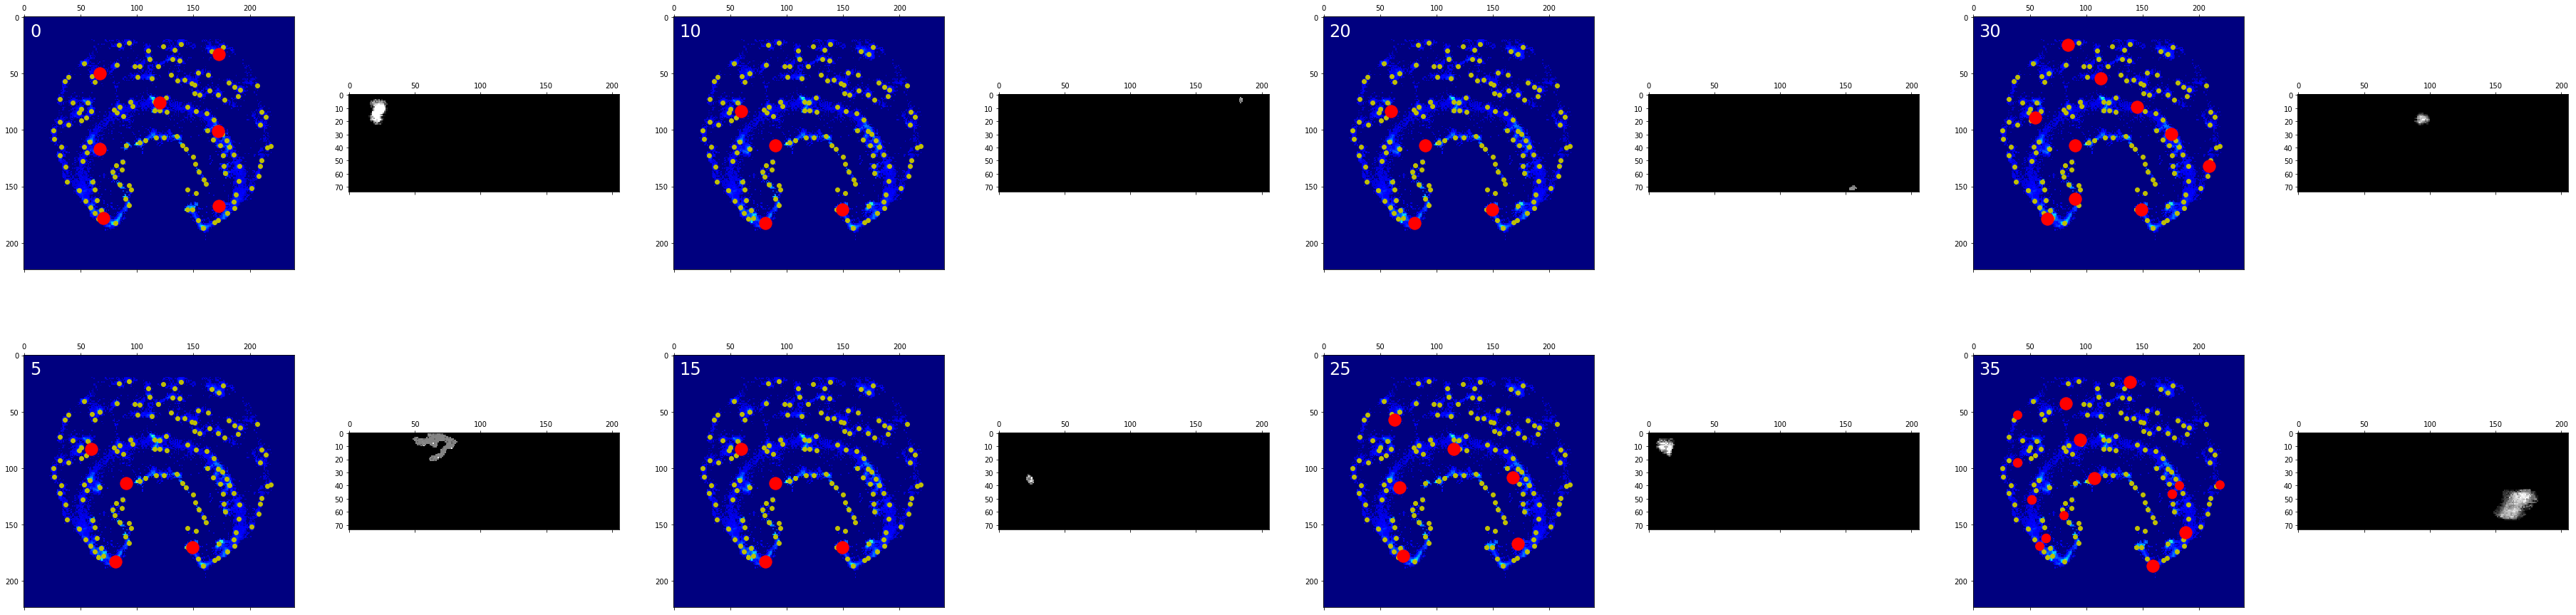

In [93]:
sizescale = 300
show_current = False
ncols = 4
label = True
labeloffset = 5
labelsize = 24
labelcolor = 'w'
prunefactor = 5

show_classes(classification, sizescale=sizescale, show_current=show_current, ncols=ncols,
             label=label, labeloffset=labeloffset, labelsize=labelsize, labelcolor=labelcolor,
             prunefactor=prunefactor)

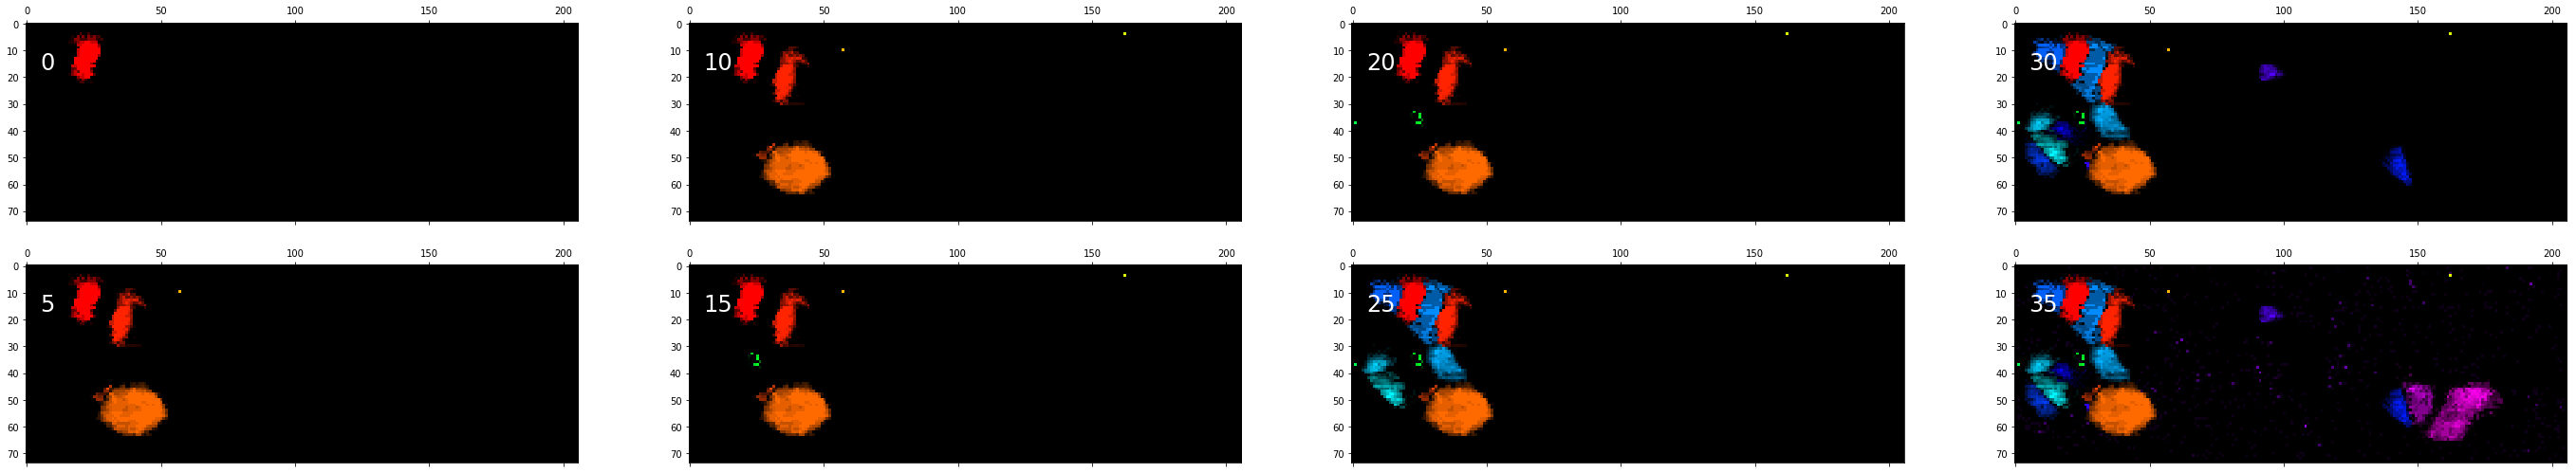

In [94]:
# Show successive class image overlay

thresh = 0.3
cmap = 'hsv'
show_current = False
ncols=4
label = True
labeloffset = 5
labelsize = 24
labelcolor = 'w'
prunefactor = 5

aspect_ratio = classification.get_class_image(0).shape[1]/classification.get_class_image(0).shape[0]
show_stepwise_classification(classification, thresh=thresh, cmap=cmap, show_current=show_current,
                             aspect_ratio=aspect_ratio, ncols=ncols,
                             label=label, labeloffset=labeloffset, labelsize=labelsize, labelcolor=labelcolor,
                             prunefactor=prunefactor)

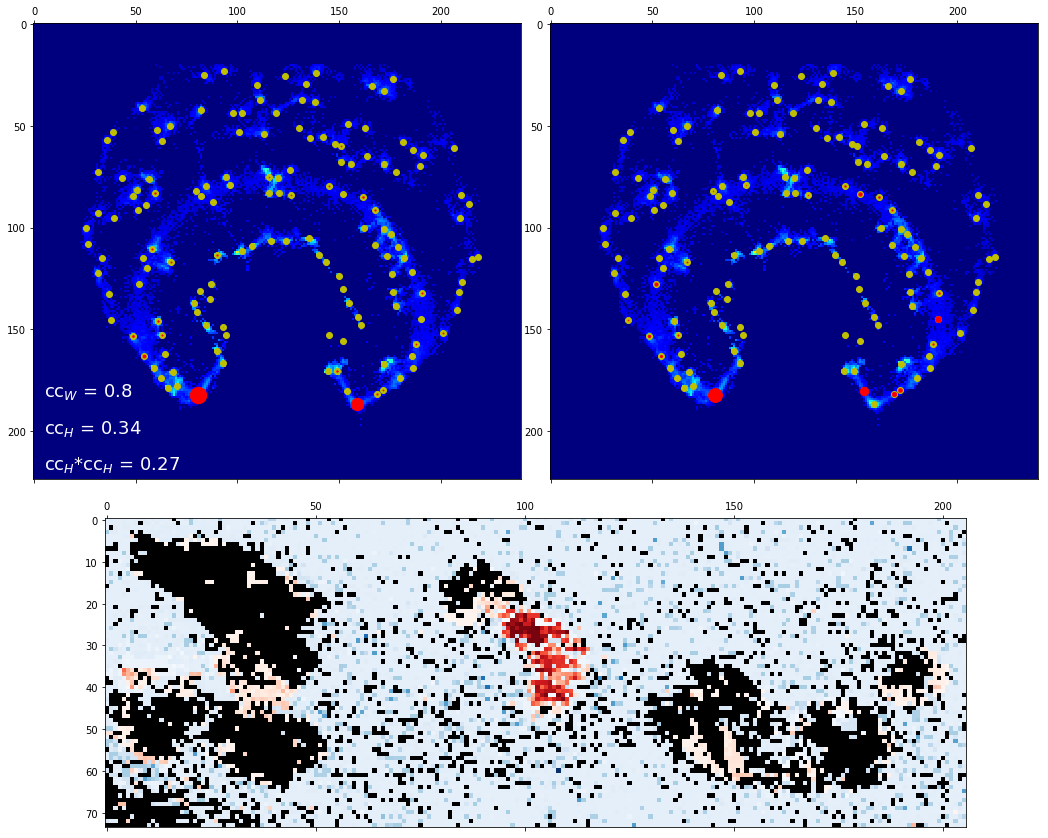

In [50]:
n_merge_candidate = 0
sizescale = 100
thresh=threshScanPosition
label = True
labeloffset = 5
labelsize = 18
labelcolor = 'w'

show_merge_candidates(classification=classification, merge_candidates=merge_candidates,
                      n_merge_candidate=n_merge_candidate, thresh=thresh, sizescale=sizescale, label=label,
                      labeloffset=labeloffset, labelsize=labelsize, labelcolor=labelcolor)

In [99]:
classification.accept()

### Nonnegative matrix factorization

In [40]:
max_iterations = 2

classification.nmf(max_iterations=max_iterations)

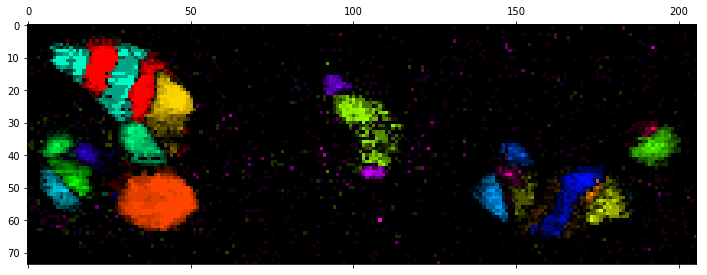

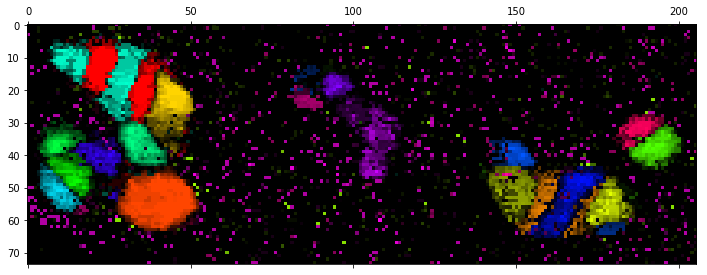

In [41]:
# Show class image overlay

thresh = 0.3
cmap = 'hsv'

show_classification(classification, thresh=thresh, cmap=cmap, show_current=True)
show_classification(classification, thresh=thresh, cmap=cmap, show_current=False)

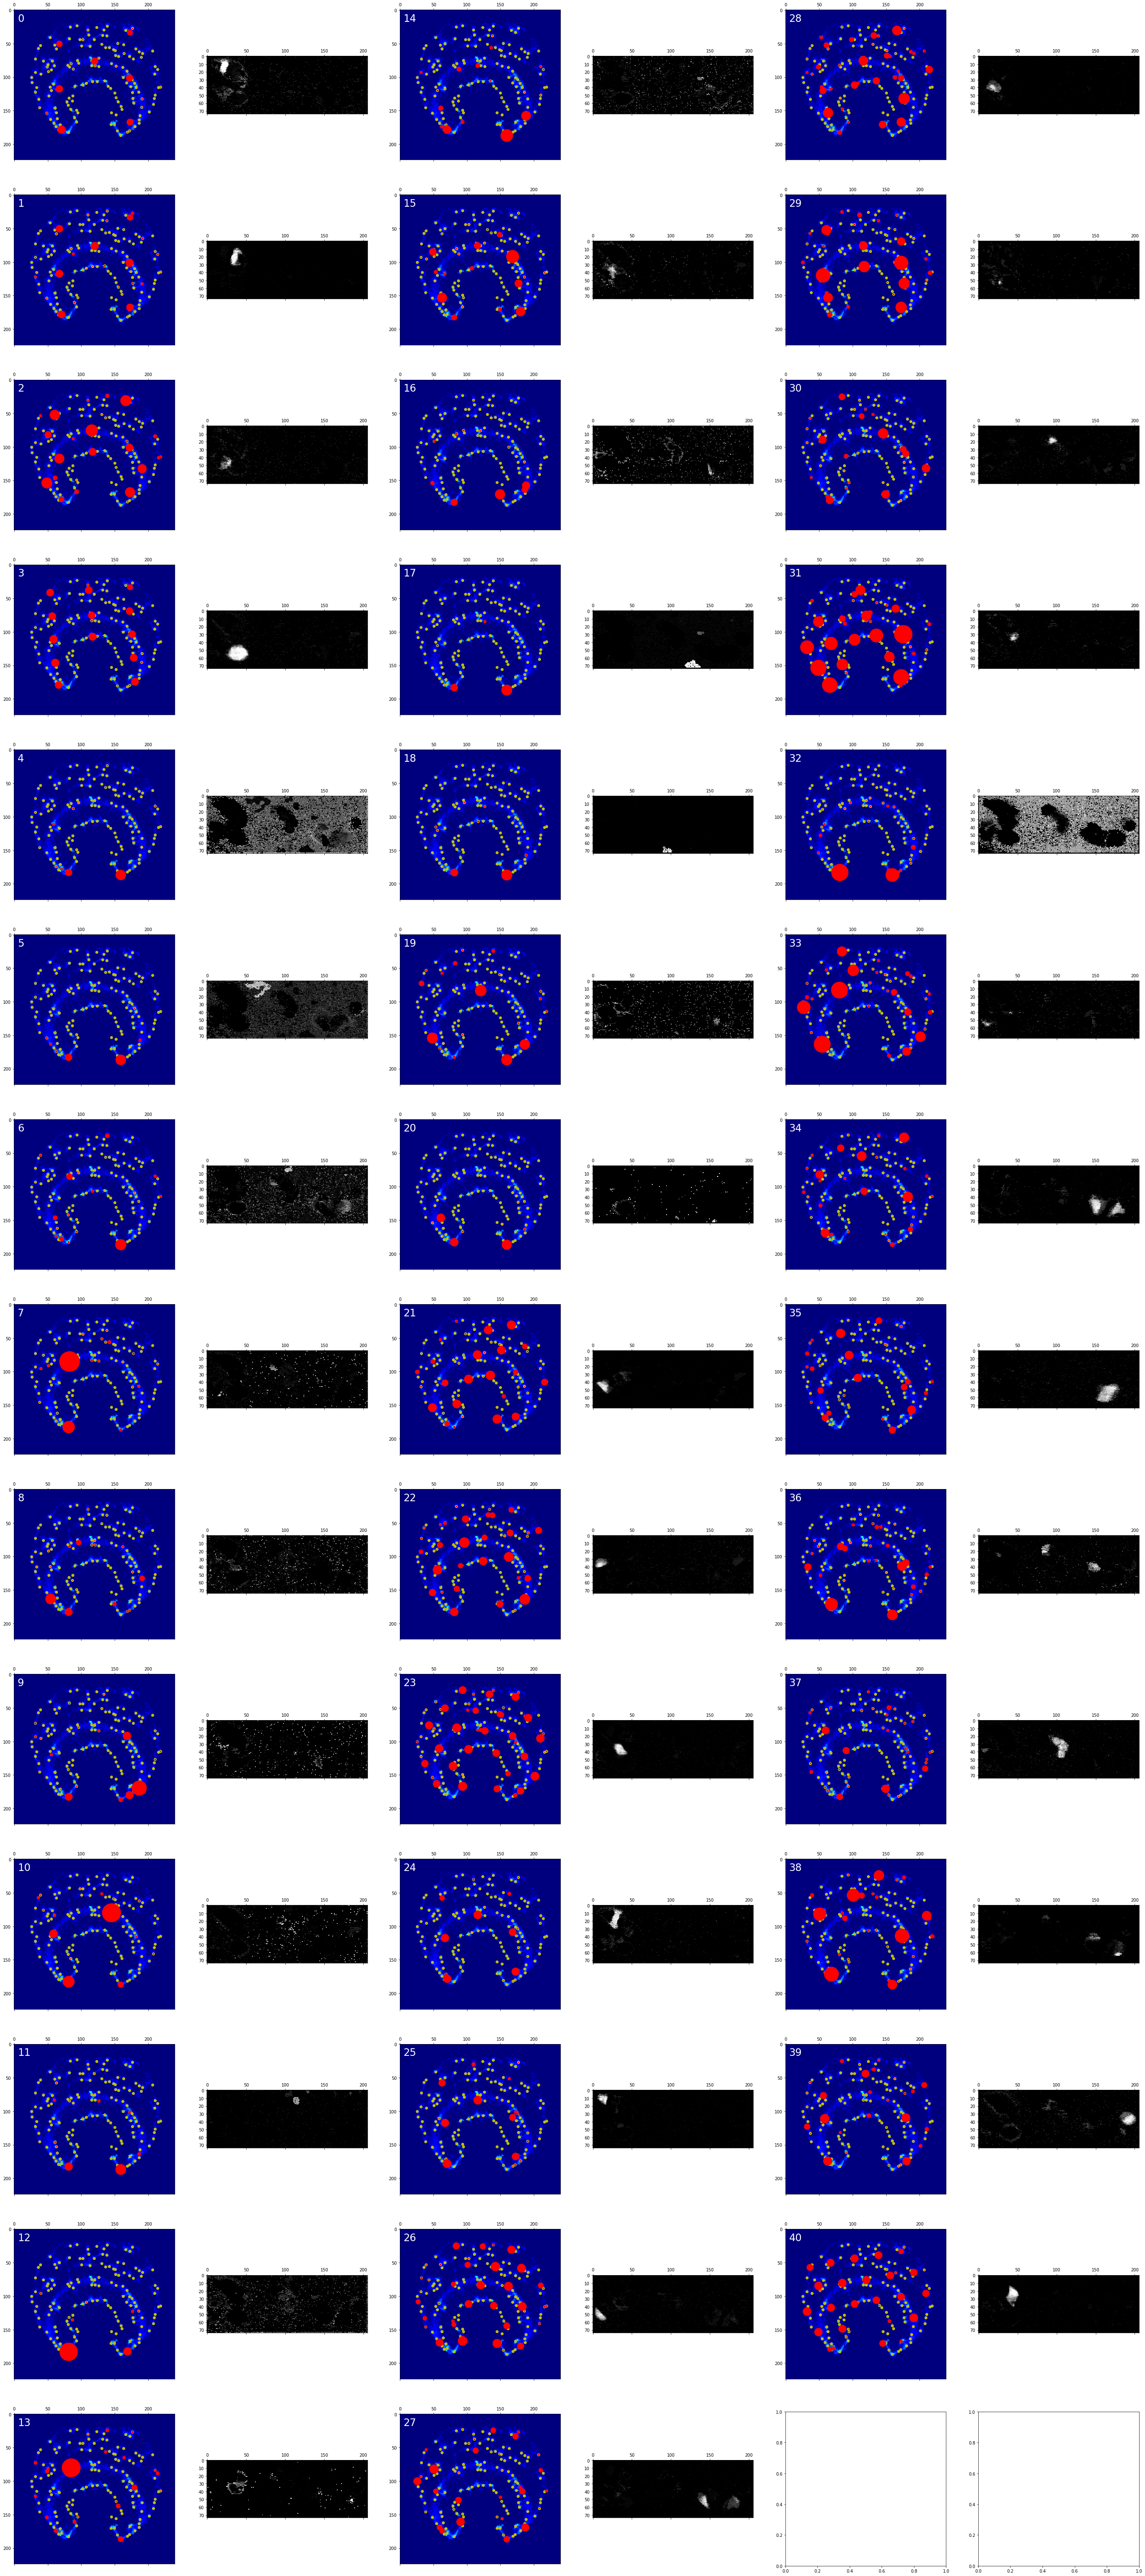

In [113]:
# Show all classes

sizescale = 300
show_current = False
ncols = 3
label = True
labeloffset = 5
labelsize = 24
labelcolor = 'w'
prunefactor = 1

show_classes(classification, sizescale=sizescale, show_current=show_current, ncols=ncols,
             label=label, labeloffset=labeloffset, labelsize=labelsize, labelcolor=labelcolor,
             prunefactor=prunefactor)

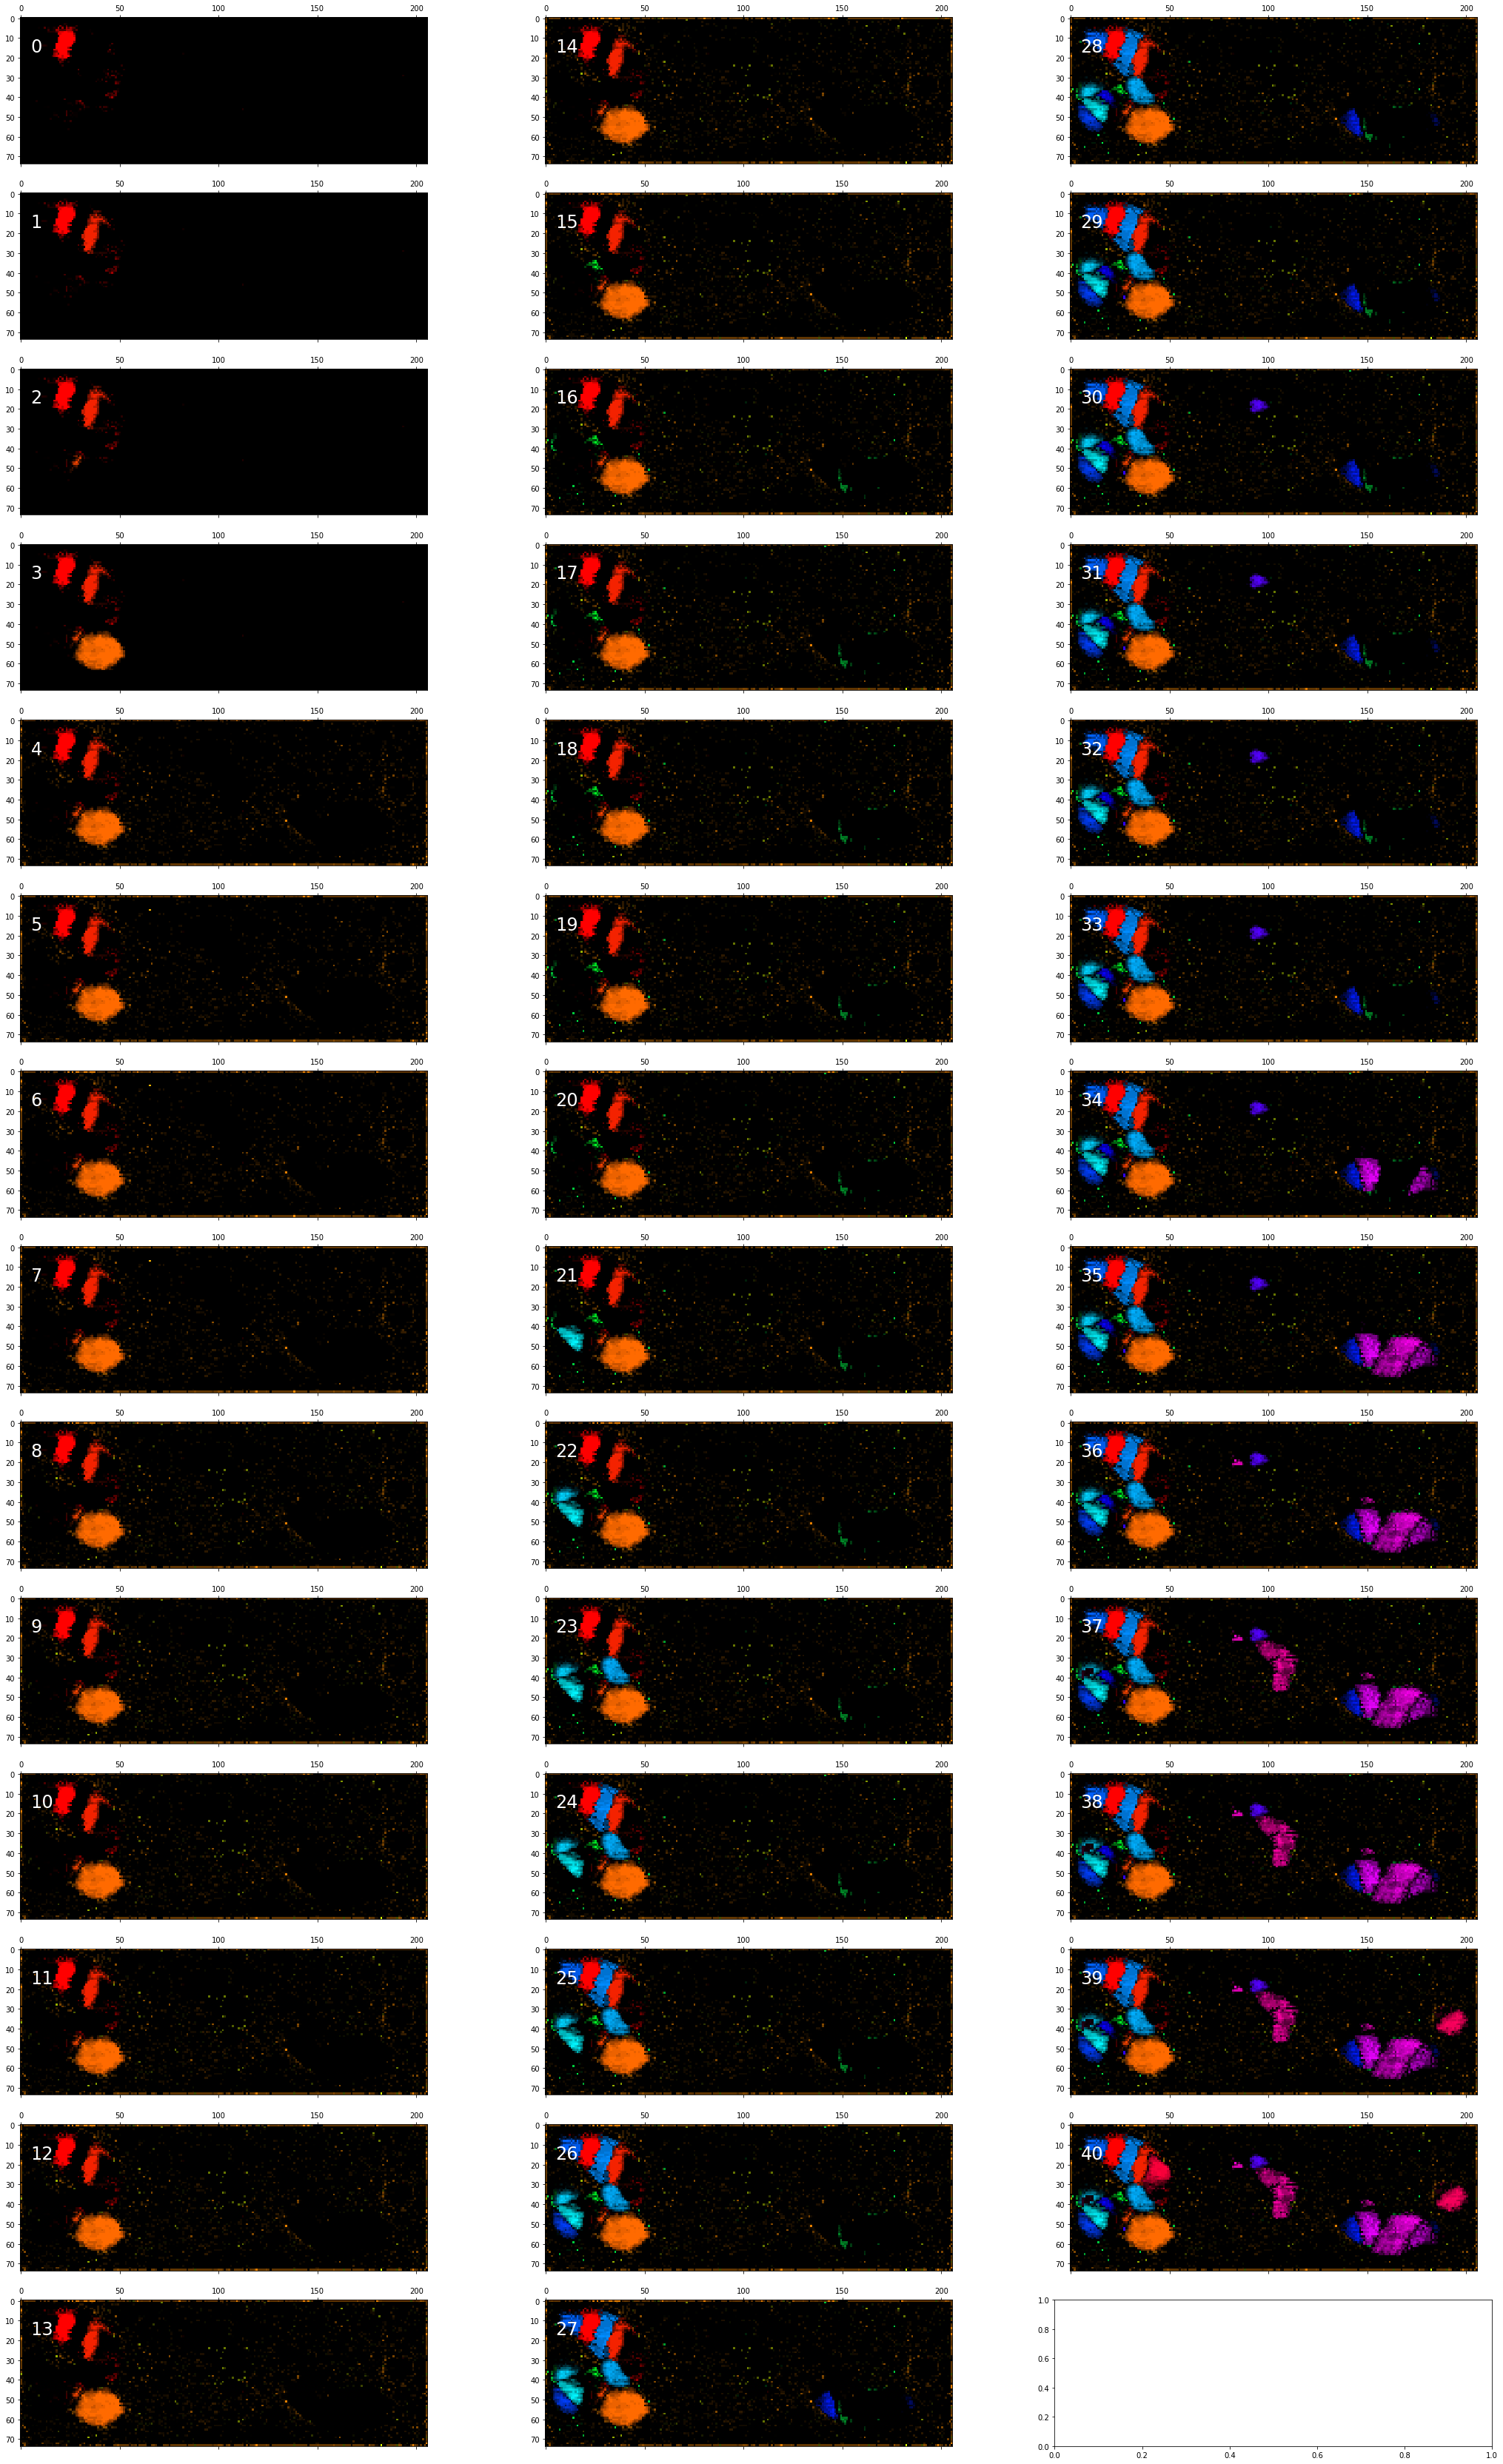

In [114]:
# Show successive class image overlay

thresh = 0.3
cmap = 'hsv'
show_current = False
ncols=3
label = True
labeloffset = 5
labelsize = 24
labelcolor = 'w'
prunefactor = 1

aspect_ratio = classification.get_class_image(0).shape[1]/classification.get_class_image(0).shape[0]
show_stepwise_classification(classification, thresh=thresh, cmap=cmap, show_current=show_current,
                             aspect_ratio=aspect_ratio, ncols=ncols,
                             label=label, labeloffset=labeloffset, labelsize=labelsize, labelcolor=labelcolor,
                             prunefactor=prunefactor)

In [ ]:
classification.accept()

### Iteratively merge

In [57]:
threshBPs = 0.25
threshScanPosition = 0.1

classification.merge_iterative(threshBPs=threshBPs, threshScanPosition=threshScanPosition)

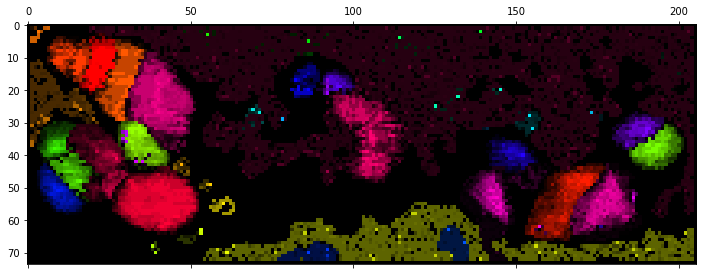

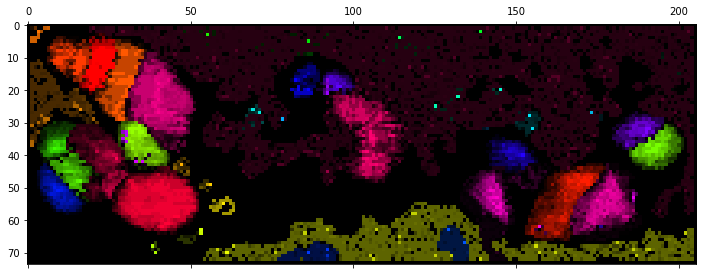

In [59]:
# Show class image overlay

thresh = 0.1
cmap = 'hsv'

show_classification(classification, thresh=thresh, cmap=cmap, show_current=True)
show_classification(classification, thresh=thresh, cmap=cmap, show_current=False)

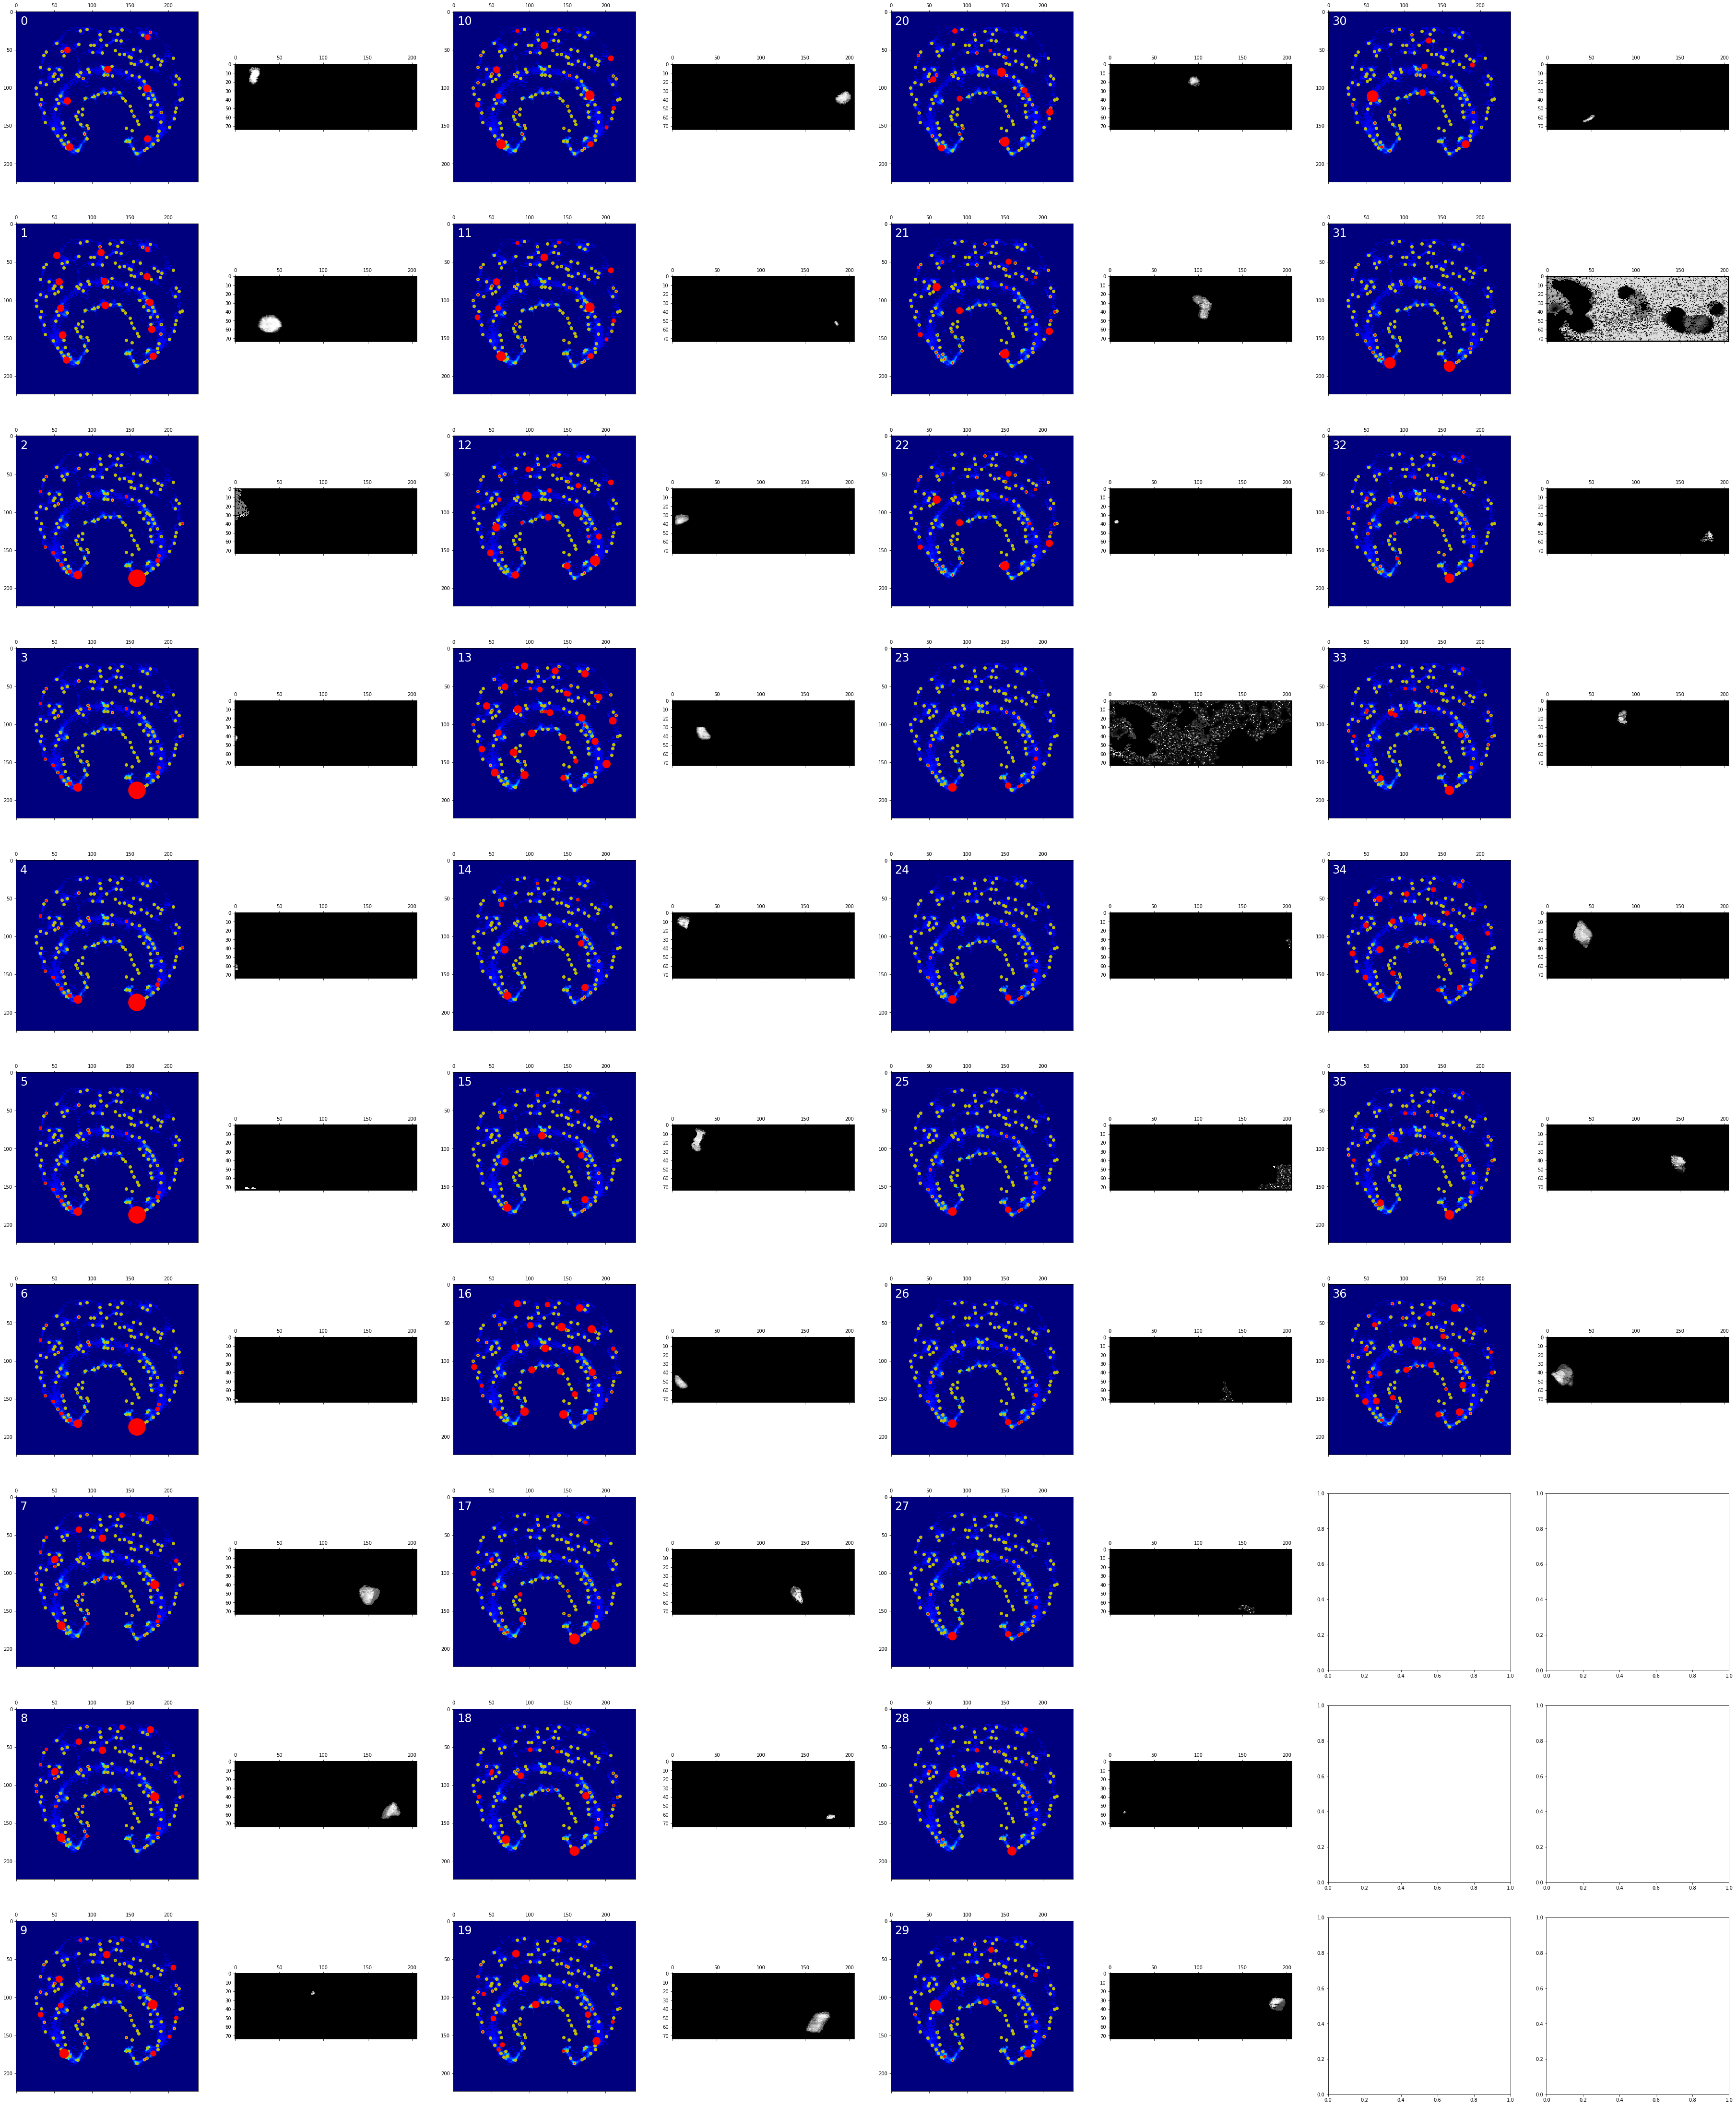

In [32]:
sizescale = 200
show_current = False
ncols = 4
label = True
labeloffset = 5
labelsize = 24
labelcolor = 'w'
prunefactor = 1

show_classes(classification, sizescale=sizescale, show_current=show_current, ncols=ncols,
             label=label, labeloffset=labeloffset, labelsize=labelsize, labelcolor=labelcolor,
             prunefactor=prunefactor)

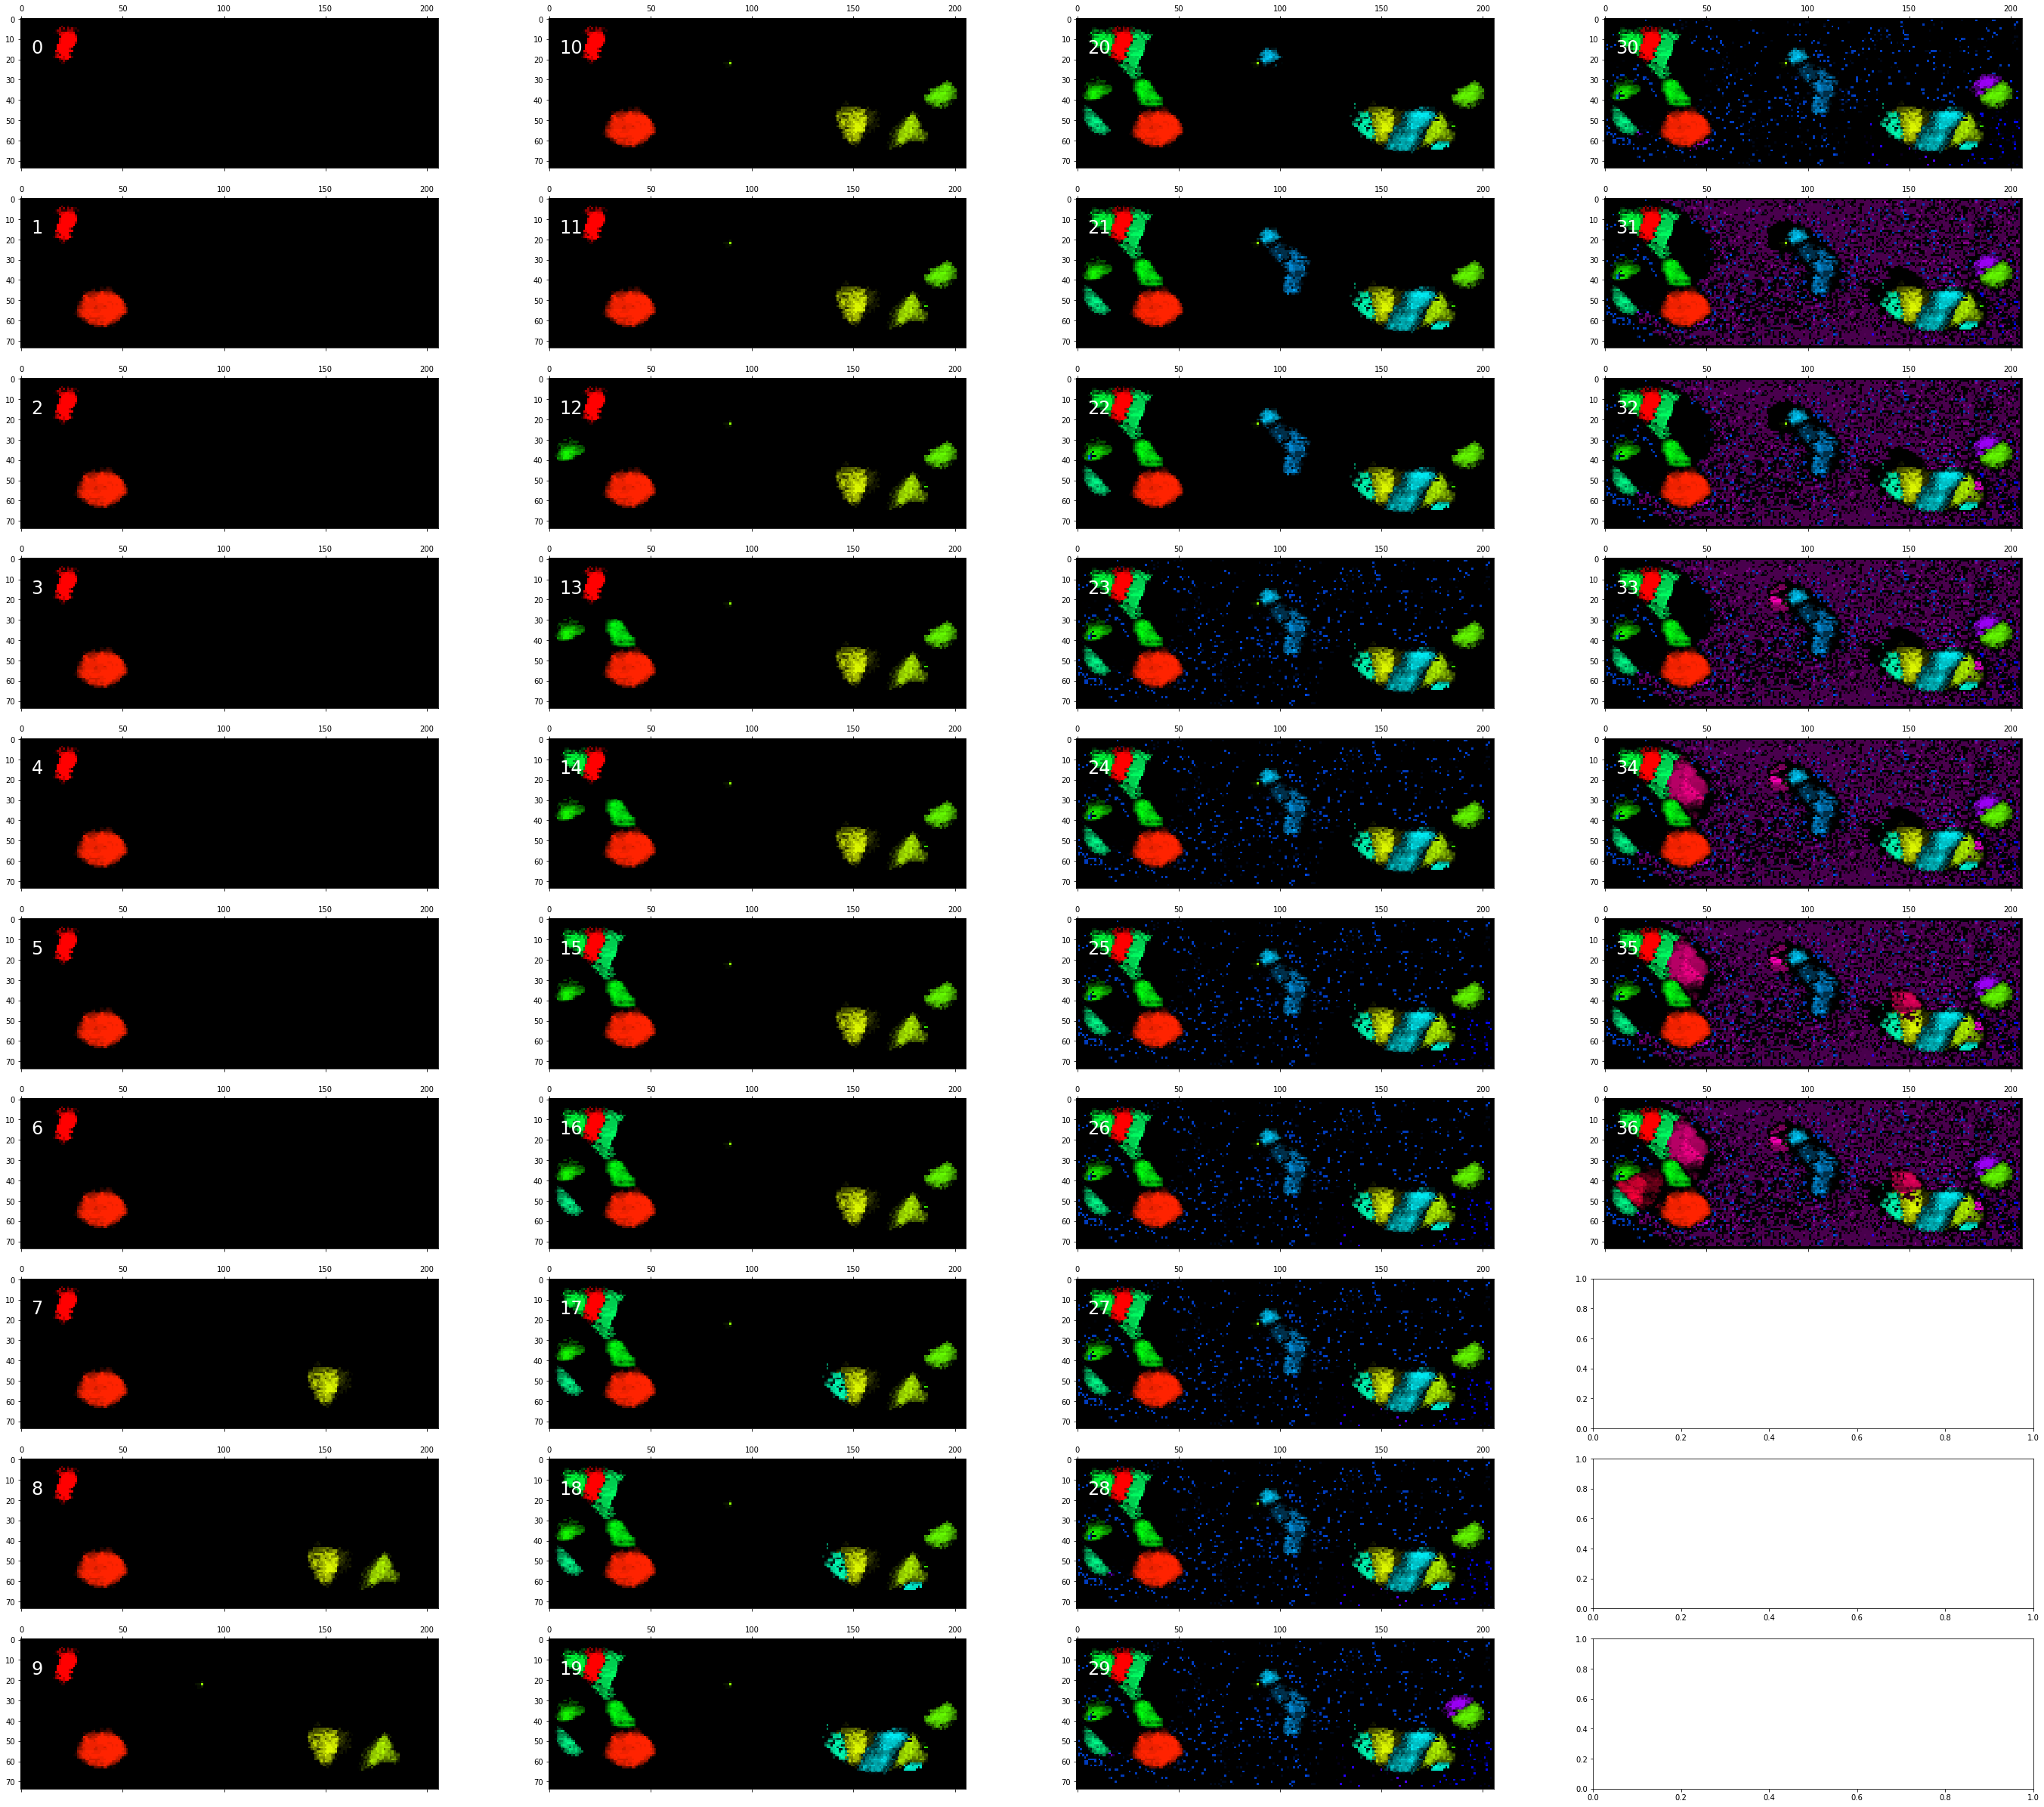

In [33]:
# Show successive class image overlay

thresh = 0.3
cmap = 'hsv'
show_current = False
ncols=4
label = True
labeloffset = 5
labelsize = 24
labelcolor = 'w'
prunefactor = 1

aspect_ratio = classification.get_class_image(0).shape[1]/classification.get_class_image(0).shape[0]
show_stepwise_classification(classification, thresh=thresh, cmap=cmap, show_current=show_current,
                             aspect_ratio=aspect_ratio, ncols=ncols,
                             label=label, labeloffset=labeloffset, labelsize=labelsize, labelcolor=labelcolor,
                             prunefactor=prunefactor)

In [60]:
classification.accept()
    